# Fly Flip Notebook
- First label images front and back
Then what we will do and then we can see if they face the front
- First orient all the images so they face the front...
- Second we will take the mean mask and ensure that it is oriented in the center so all masks need to be centered in the image
-

Will then use the average/mean mask as a template. With this template we should be able to compare to the original images and then determine the orientation.

Then will examine effectivness on test dataset..

Phases:
1. Import Depandencies
2. Set Data Source
3. Perform Image Labeling
    - Currently using OpenCV Method
    - Next Method: Using Tkinter GUI
4. Development of Average Mask
5. MSE Comparison
6. Plot of MSE

## Import Libraries

In [2]:
# Import Libraries
import sys
import os
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cv2
import copy
import glob
import tkinter as tk
current_dir = os.path.dirname(os.getcwd())
print(current_dir)
# plot_dir = os.path.join(current_dir,'plotting')
sys.path.append(current_dir)
# print(sys.path)
from lib.plotting import polarplot as polarplt# polar plotting module
from lib.parsing import basic_sections as bsc_sec # basic data parsing methods
from lib.parsing.data_range import find_startdata, find_enddata # setting start and end of analysis region 
from lib.parsing.exact_exp_groups import sub_exp_group  # more dataparsing methods
from lib.led_convert import get_LED_angle_in_rad
from lib.plotting.flyviz import get_contour_centroid, get_objectmask, get_fill_flymask, contour_hrz_matrix
from scipy import interpolate
from find_fly_angle.find_fly_anglev2 import *

/home/loganrower/project_repos/flyplot
Initialized Plotting Package
Initialized Parsing Package


## Set Data Source

Provide path to the image dataset that will be referenced throughout this notebook.

In [40]:
# Path to Image Dataset
# MacOS
# data = glob.glob('/Volumes/No Name/20240502125110/*.png')
# Windows
# data = glob.glob('D:/20240502125110/*.png')
# Linux
data = glob.glob('/media/loganrower/D5E2-7968/20240502125110/*.png')

Determine the number of images in the dataset

In [41]:
for f in range(len(data)):
# np.where(file.split('/')[-1].strip('.png') == 20240502125110_5669')
    if data[f].split('/')[-1].split('\\')[-1].strip('.png') == '20240502125110_1332':
        print(f)

1137


## (Optional) Test Image

To ensure that all dependancies are working appropriately, an image source internally within this package will be used to test the `contour_hrz_matrix` method.

Alternatively, you can utilize a different image.

In [43]:
file ="20240415120905_0121"
file_name = "imgs/" + file +".png"
fly_mask_orig, fly_mask_hrz,max_contour_hrz,centroid_hrz, body_axis_pt_0_hrz,body_axis_pt_1_hrz, angle_og, angle_rot = contour_hrz_matrix(file_name)

Angle Test!
Angle Value: -150.81302529857444
My Angle Value: 238.3739494028511
Angle Test!
Angle Value: 89.07785336571138
My Angle Value: 358.15570673142275


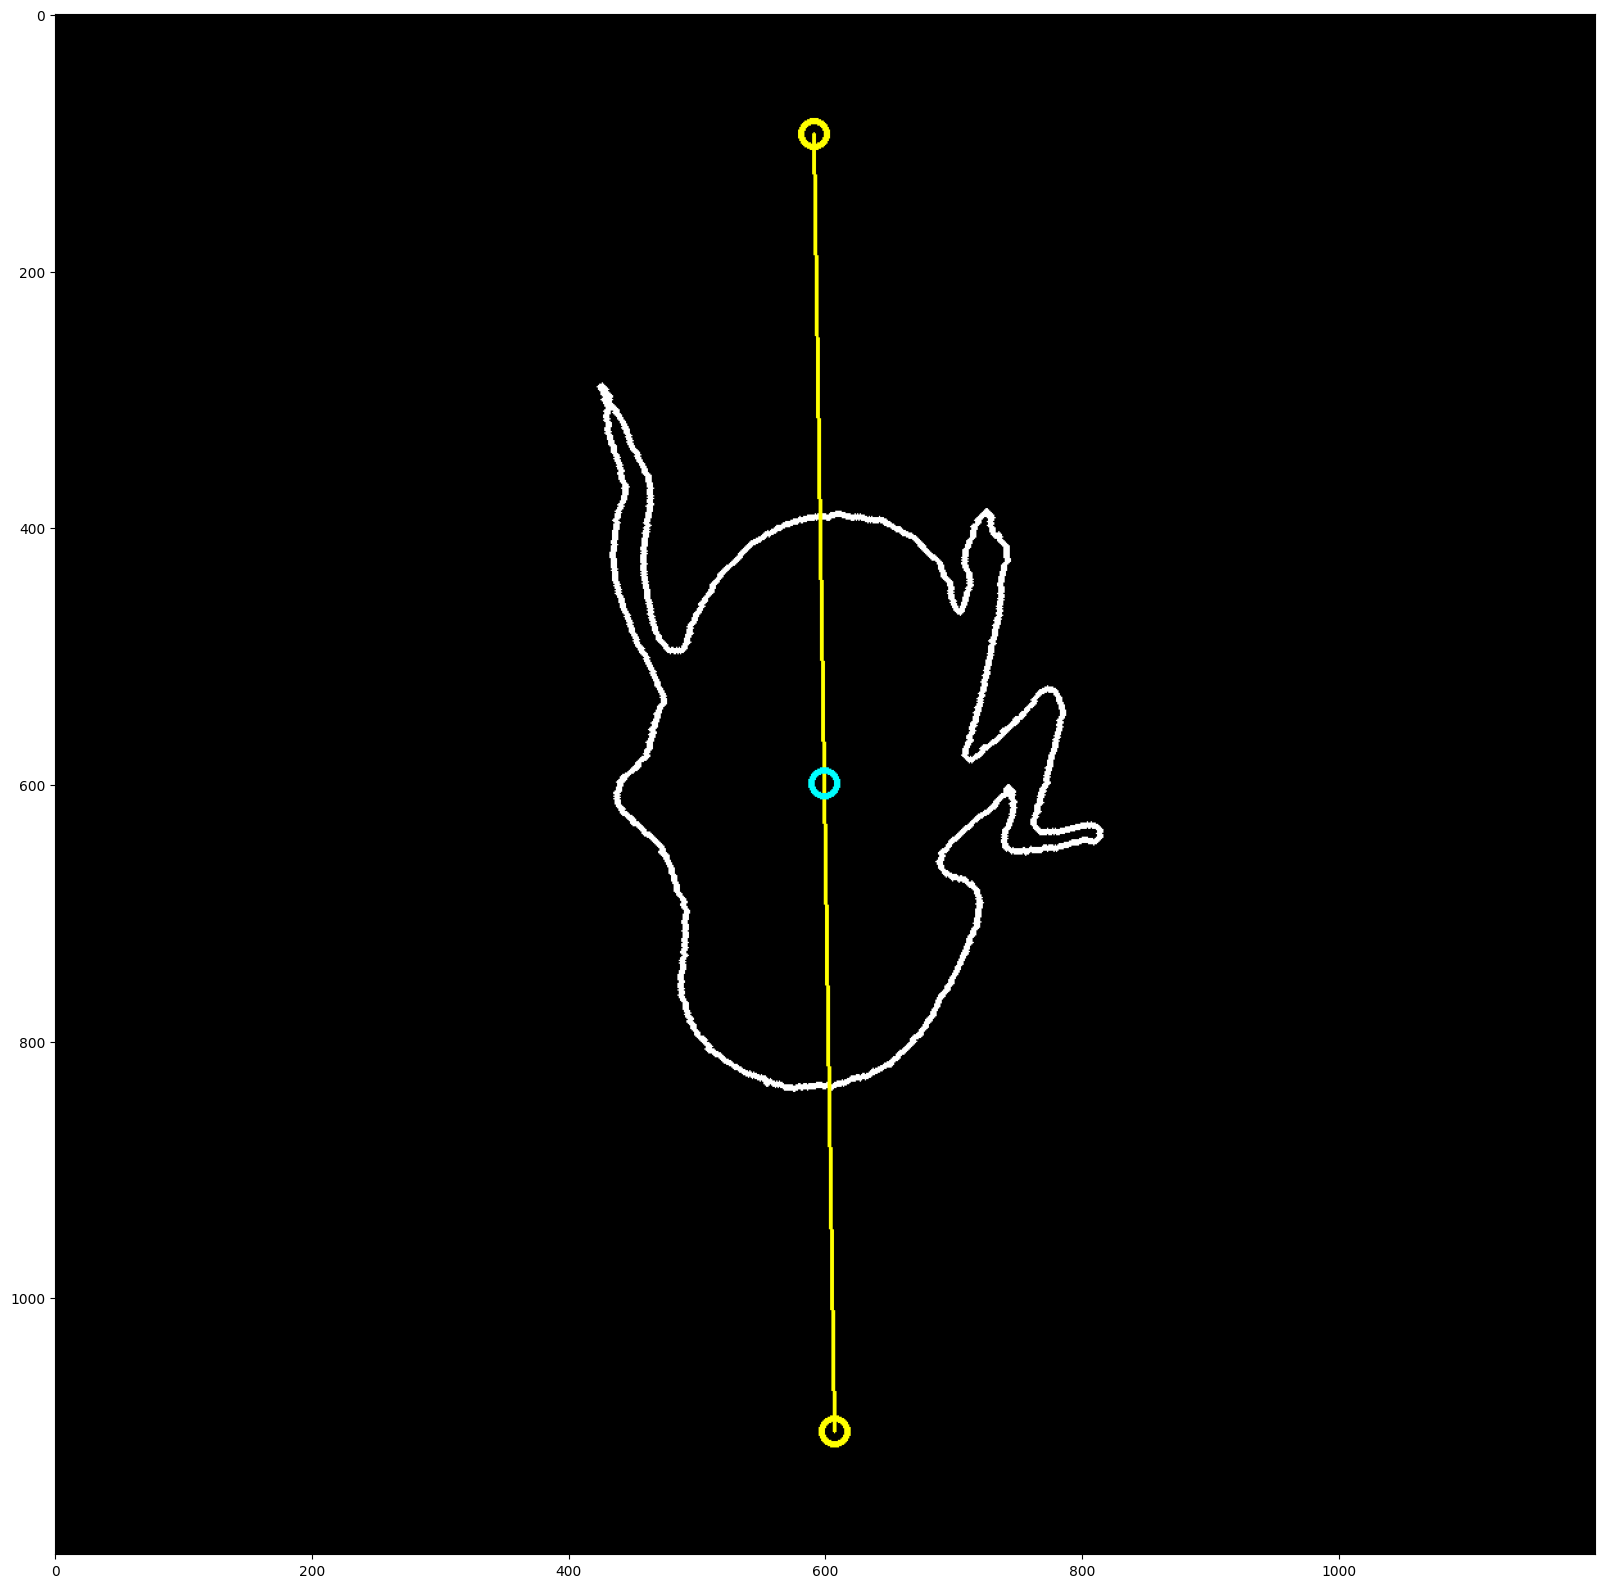

In [44]:
plt.figure(figsize=(20,20))
mask_fly = get_objectmask(fly_mask_hrz,max_contour_hrz)

cv2.circle(mask_fly,body_axis_pt_0_hrz,10, color = (255,255,0),thickness =3)
cv2.circle(mask_fly,body_axis_pt_1_hrz,10, color = (255,255,0),thickness =3)
cv2.line(mask_fly,body_axis_pt_0_hrz,body_axis_pt_1_hrz,color = (255,255,0), thickness = 2)
cv2.circle(mask_fly,centroid_hrz,10,color = (0,255,255),thickness=3)
plt.imshow(mask_fly)

## Labeling
After verifying that your dependancies are working, proceed to label 20 random images of flies from the path provided initially. The labeling process is to assign each image an indication of whether or not the Non Rotated or Rotated image best represents a Fly.

Three Images will be displayed, with the first image represeting the original fly orientation, the second the rotated and transformed fly based on it's orientation (which will allow it to be oriented along the central vertical axis). The last image is a subsequent 180 degree rotation of the fly after the initial rotation and transformation....

Essentially the labeling is a selection between the last two images. After making this selection that image will be saved in order to generate an average mask.

The Criteria for Labeling:
- Fly head facing up in an image then use the respective 'n' or 'r' to assign that image to the fly. with `n` corresponding to `No Rotation` and `r` corresponding to `Rotation`

In [47]:
imgs = {}
import time
import glob
import random
def img_label(filename):
    """
    For each image we will need to ensure that the proper rotation is performed such that it is in the 
    top down rotation
    
    """
    fly_mask_orig, fly_mask_hrz,max_contour_hrz,centroid_hrz, body_axis_pt_0_hrz,body_axis_pt_1_hrz,angle_og,angle_rot= contour_hrz_matrix(filename)
# mask_fly_norot = get_objectmask(fly_mask_hrz,max_contour_hrz)
    mask_fly_rot = cv2.rotate(copy.deepcopy(fly_mask_hrz),cv2.ROTATE_180)
    dict_img ={
        "n": fly_mask_hrz,
        "r":mask_fly_rot
    }
#     for i in range(1):
    ## test various rotations (0 or 180)
    fig = plt.figure(figsize=(20,20))
    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(fly_mask_orig,cmap='gray')
    print(f"<< Original Angle: {np.rad2deg(angle_og)} >>")
    plt.subplot(1,3,2)
    plt.title("No Rotation")
    # print("No Rotation Angle:",np.rad2deg(angle))
    print(f"<< No Rotation Angle: {np.rad2deg(angle_og)} >>")
    plt.imshow(fly_mask_hrz,cmap='gray')
    plt.subplot(1,3,3)
    plt.title("Rotation")
    print(f"<< Rotation Angle: {np.rad2deg(angle_og)-180} >>")
    plt.imshow(mask_fly_rot,cmap='gray')
    plt.show()
    
    fly_up = input("Input the name of No Rotation or Rotation depending on which one display fly pointed up. ")
    mask_fly = dict_img[fly_up]
    
    return mask_fly

['/media/loganrower/D5E2-7968/20240502125110/20240502125110_6077.png', '/media/loganrower/D5E2-7968/20240502125110/20240502125110_6274.png', '/media/loganrower/D5E2-7968/20240502125110/20240502125110_6820.png', '/media/loganrower/D5E2-7968/20240502125110/20240502125110_2444.png', '/media/loganrower/D5E2-7968/20240502125110/20240502125110_7783.png', '/media/loganrower/D5E2-7968/20240502125110/20240502125110_3469.png', '/media/loganrower/D5E2-7968/20240502125110/20240502125110_2695.png', '/media/loganrower/D5E2-7968/20240502125110/20240502125110_7982.png', '/media/loganrower/D5E2-7968/20240502125110/20240502125110_7811.png', '/media/loganrower/D5E2-7968/20240502125110/20240502125110_7595.png', '/media/loganrower/D5E2-7968/20240502125110/20240502125110_3417.png', '/media/loganrower/D5E2-7968/20240502125110/20240502125110_6719.png', '/media/loganrower/D5E2-7968/20240502125110/20240502125110_6617.png', '/media/loganrower/D5E2-7968/20240502125110/20240502125110_4421.png', '/media/loganrower/

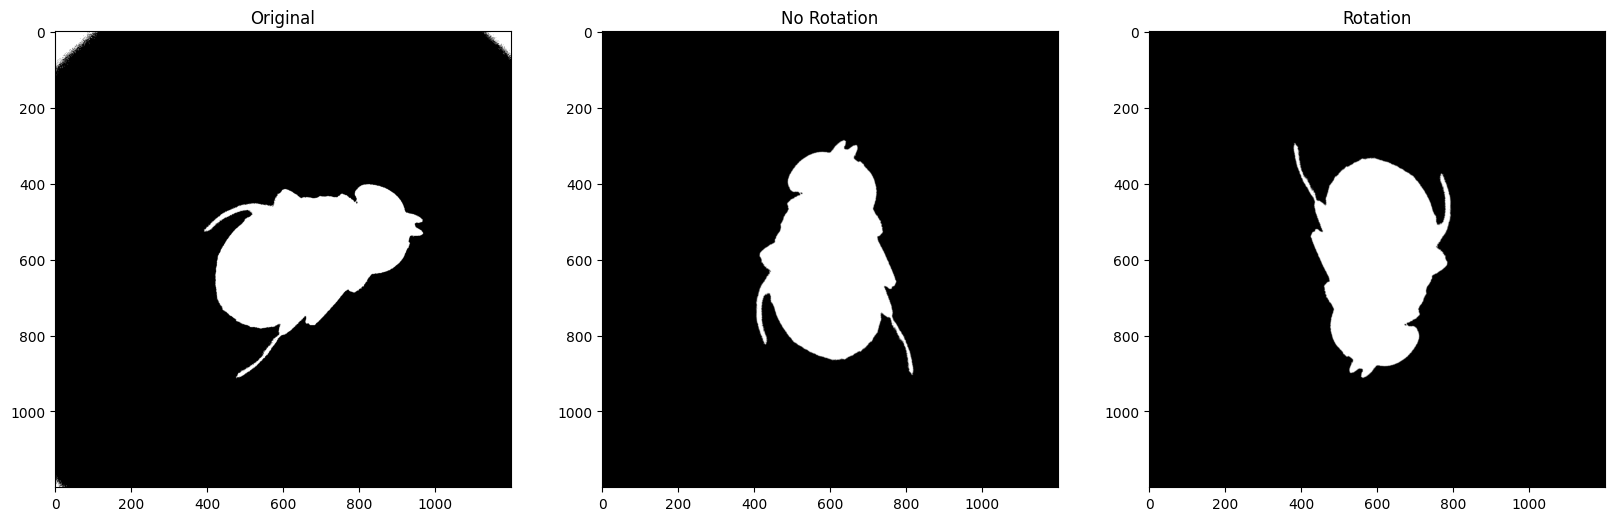

Angle Test!
Angle Value: 110.24061164849404
My Angle Value: 40.48122329698805
Angle Test!
Angle Value: 89.9637012482869
My Angle Value: 359.9274024965738
<< Original Angle: 110.24061164849404 >>
<< No Rotation Angle: 110.24061164849404 >>
<< Rotation Angle: -69.75938835150596 >>


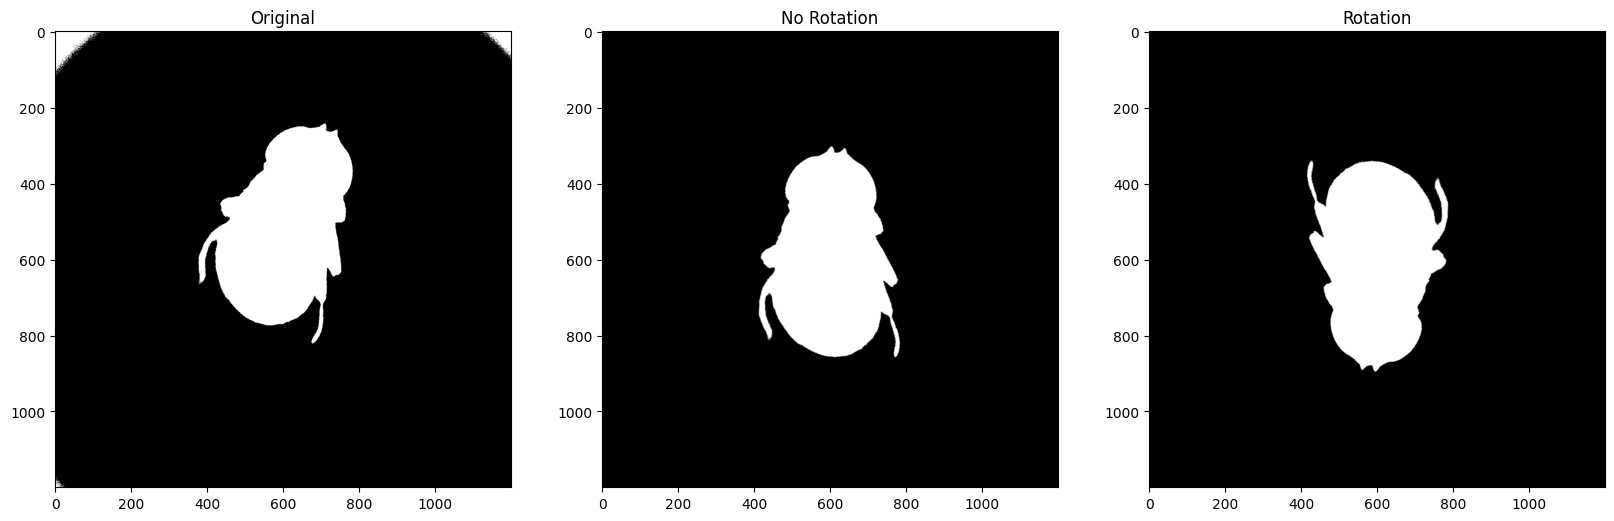

Angle Test!
Angle Value: 78.51324246176725
My Angle Value: 337.0264849235345
Angle Test!
Angle Value: 89.90828175122672
My Angle Value: 359.81656350245345
<< Original Angle: 78.51324246176728 >>
<< No Rotation Angle: 78.51324246176728 >>
<< Rotation Angle: -101.48675753823272 >>


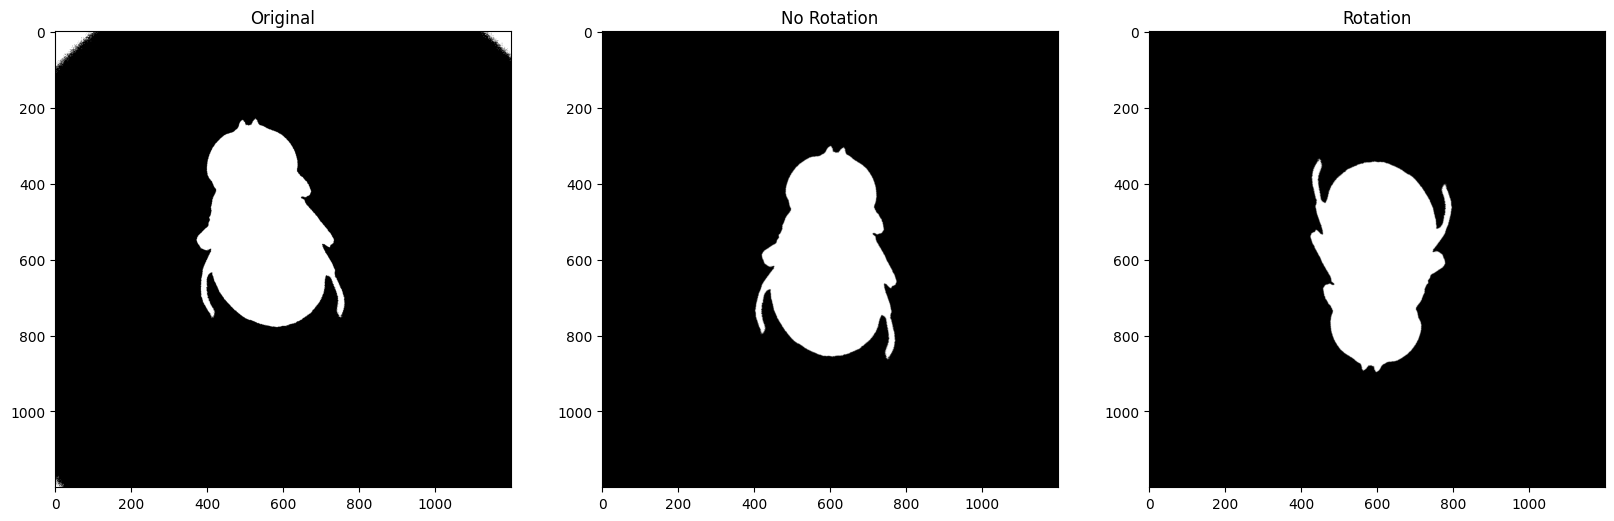

Angle Test!
Angle Value: 86.87161748440016
My Angle Value: 353.7432349688003
Angle Test!
Angle Value: 89.98696608122937
My Angle Value: 359.9739321624587
<< Original Angle: 86.87161748440016 >>
<< No Rotation Angle: 86.87161748440016 >>
<< Rotation Angle: -93.12838251559984 >>


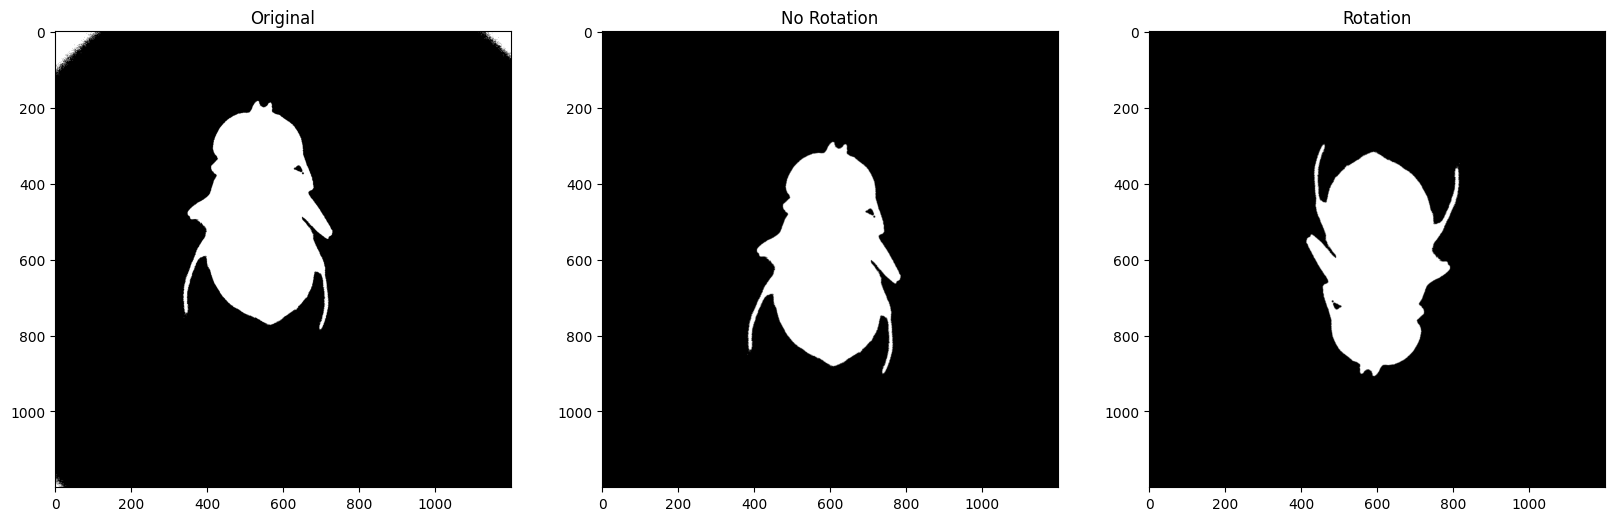

Angle Test!
Angle Value: -173.46167070494343
My Angle Value: 193.07665859011317
Angle Test!
Angle Value: 89.34164238448092
My Angle Value: 358.6832847689618
<< Original Angle: -173.46167070494343 >>
<< No Rotation Angle: -173.46167070494343 >>
<< Rotation Angle: -353.46167070494346 >>


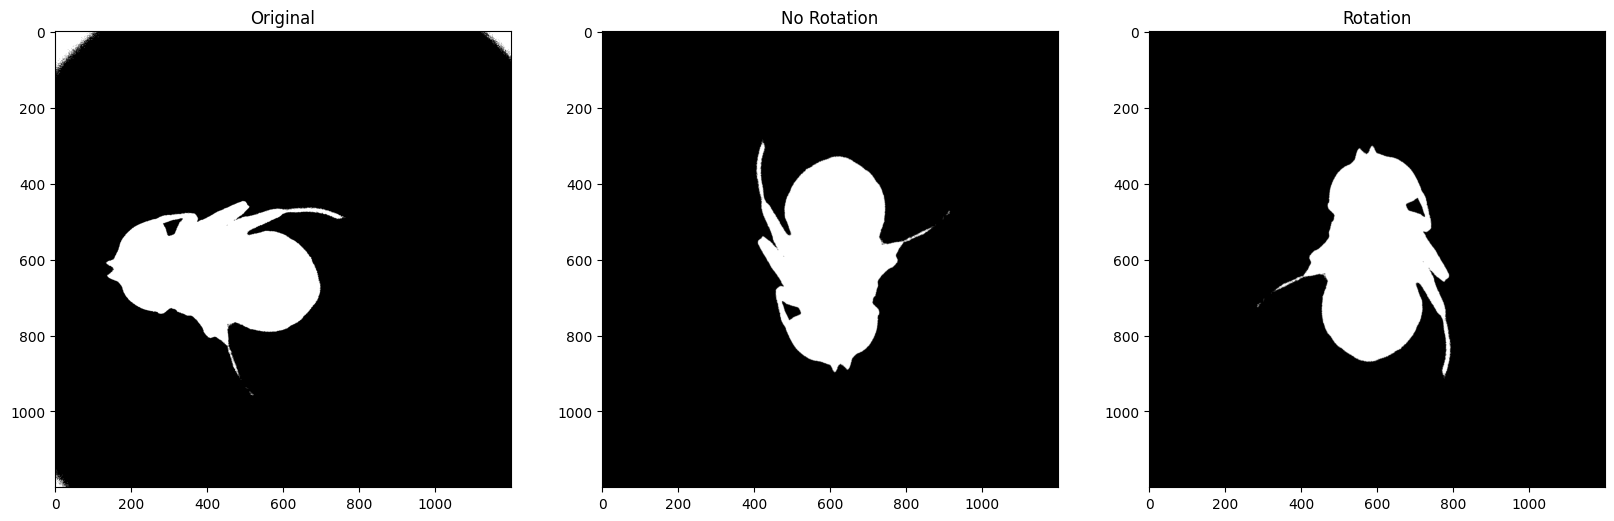

Angle Test!
Angle Value: 100.5842487737318
My Angle Value: 21.168497547463602
Angle Test!
Angle Value: 90.15163257572435
My Angle Value: 0.30326515144867017
<< Original Angle: 100.58424877373182 >>
<< No Rotation Angle: 100.58424877373182 >>
<< Rotation Angle: -79.41575122626818 >>


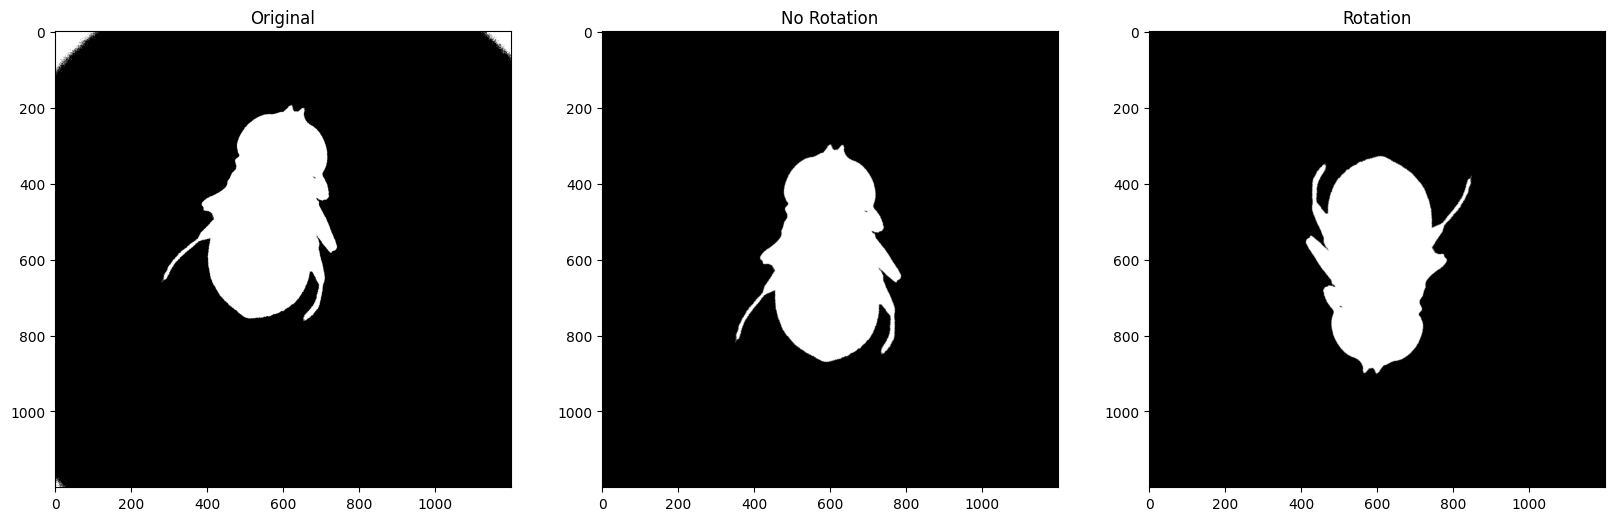

Angle Test!
Angle Value: 104.30117576166987
My Angle Value: 28.602351523339706
Angle Test!
Angle Value: 89.87822884893541
My Angle Value: 359.7564576978708
<< Original Angle: 104.30117576166988 >>
<< No Rotation Angle: 104.30117576166988 >>
<< Rotation Angle: -75.69882423833012 >>


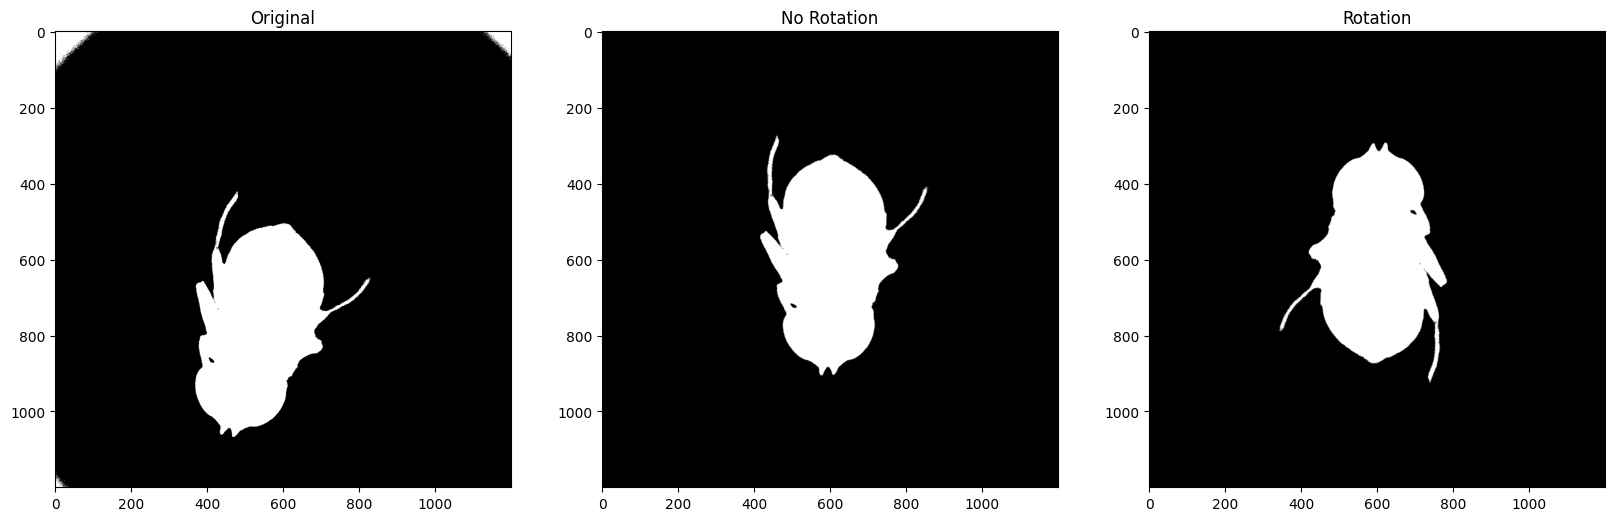

Angle Test!
Angle Value: 76.84985717443845
My Angle Value: 333.6997143488769
Angle Test!
Angle Value: 89.93795051138025
My Angle Value: 359.8759010227605
<< Original Angle: 76.84985717443848 >>
<< No Rotation Angle: 76.84985717443848 >>
<< Rotation Angle: -103.15014282556152 >>


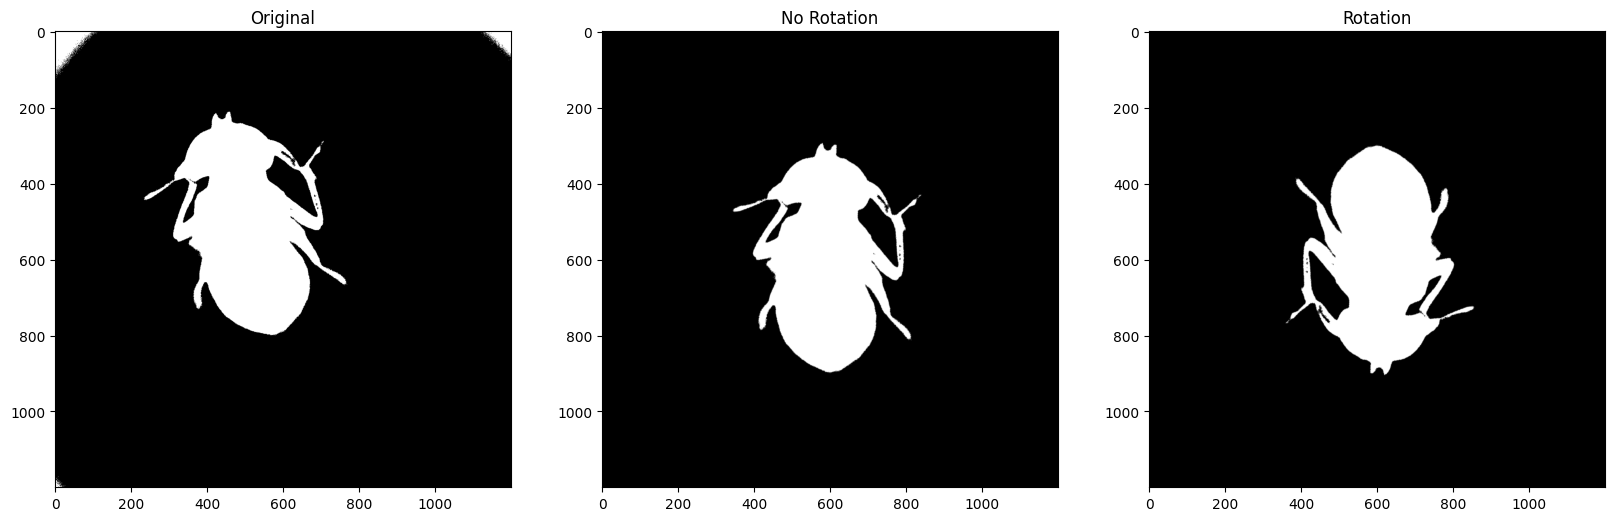

Angle Test!
Angle Value: -164.3463728797269
My Angle Value: 211.3072542405462
Angle Test!
Angle Value: 89.34196161715249
My Angle Value: 358.683923234305
<< Original Angle: -164.3463728797269 >>
<< No Rotation Angle: -164.3463728797269 >>
<< Rotation Angle: -344.3463728797269 >>


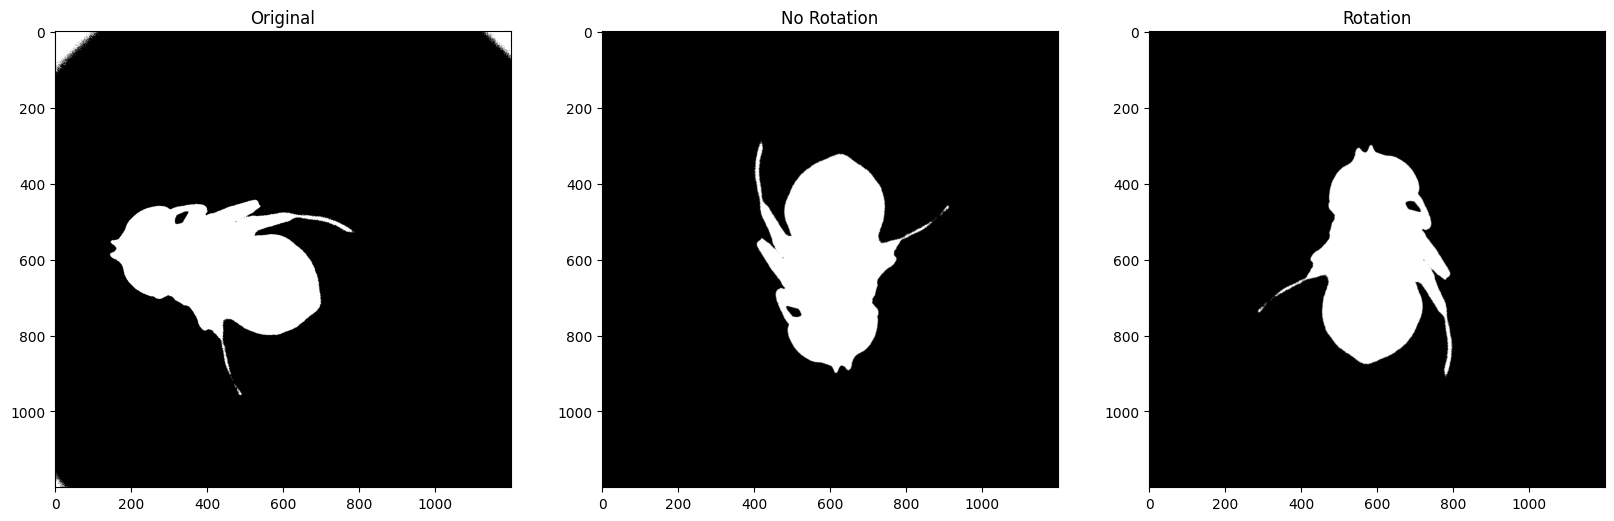

Angle Test!
Angle Value: 85.25581462658263
My Angle Value: 350.51162925316527
Angle Test!
Angle Value: 90.05884629103232
My Angle Value: 0.11769258206467725
<< Original Angle: 85.25581462658263 >>
<< No Rotation Angle: 85.25581462658263 >>
<< Rotation Angle: -94.74418537341737 >>


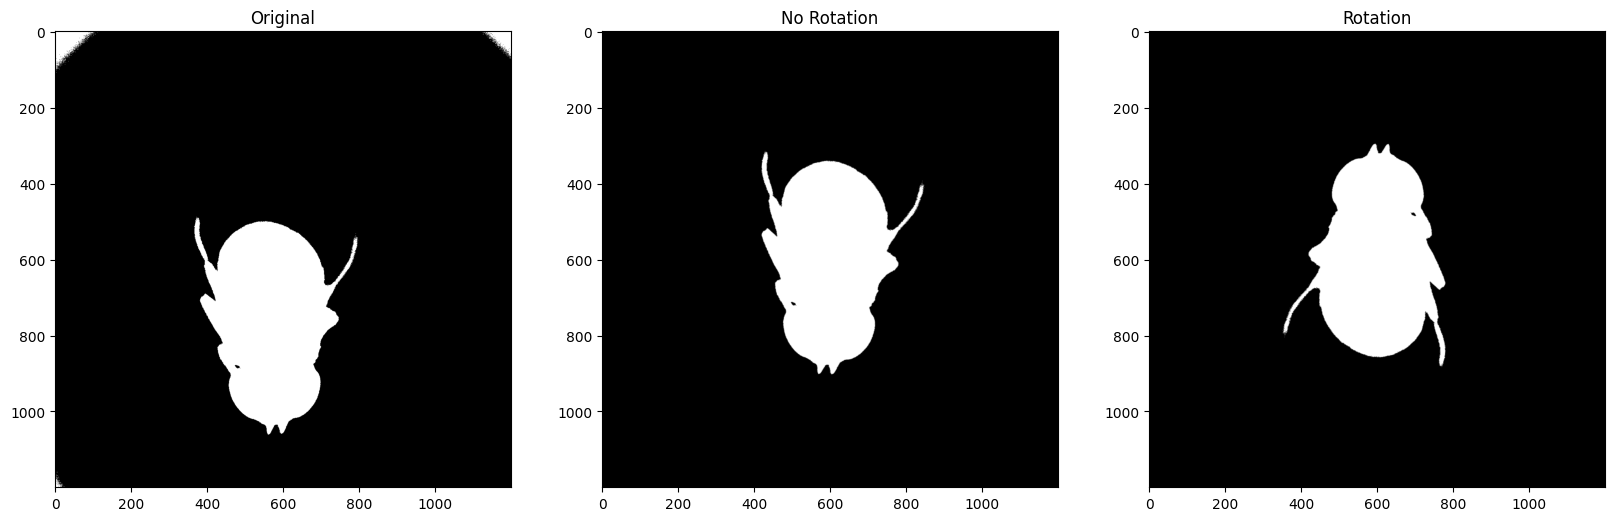

Angle Test!
Angle Value: 66.05651563842439
My Angle Value: 312.1130312768488
Angle Test!
Angle Value: 89.91328788974363
My Angle Value: 359.82657577948726
<< Original Angle: 66.0565156384244 >>
<< No Rotation Angle: 66.0565156384244 >>
<< Rotation Angle: -113.9434843615756 >>


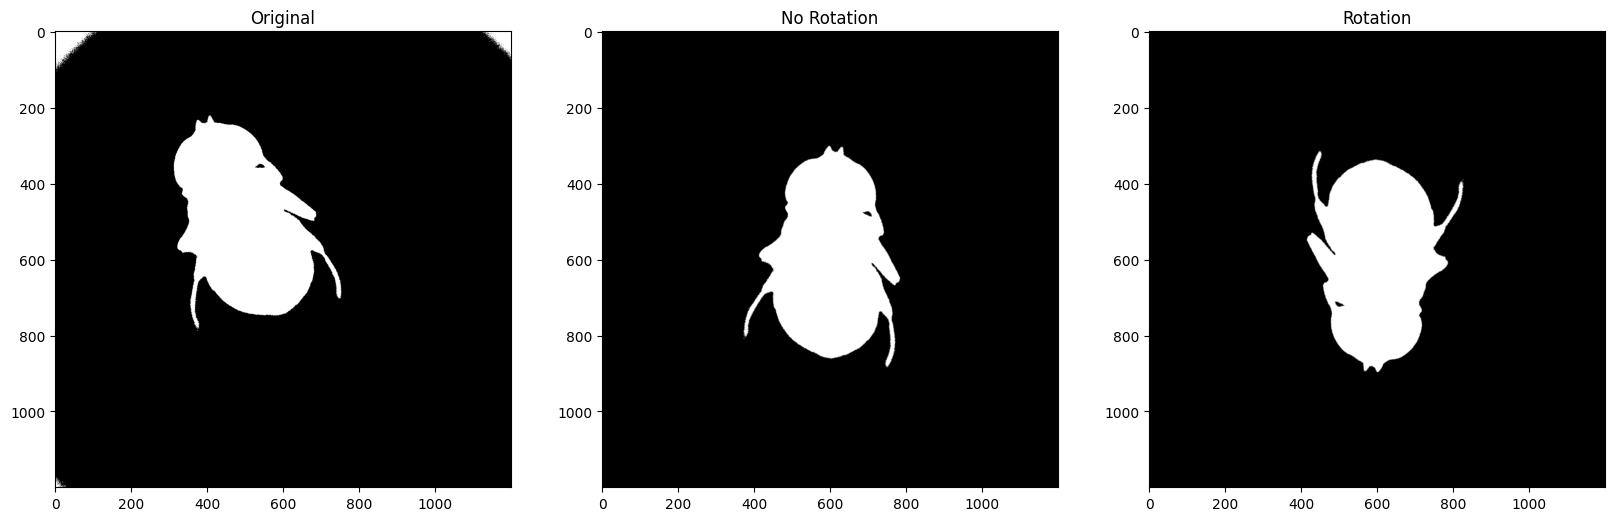

Angle Test!
Angle Value: 81.07474218747514
My Angle Value: 342.14948437495025
Angle Test!
Angle Value: 90.01005039287024
My Angle Value: 0.020100785740453375
<< Original Angle: 81.07474218747514 >>
<< No Rotation Angle: 81.07474218747514 >>
<< Rotation Angle: -98.92525781252486 >>


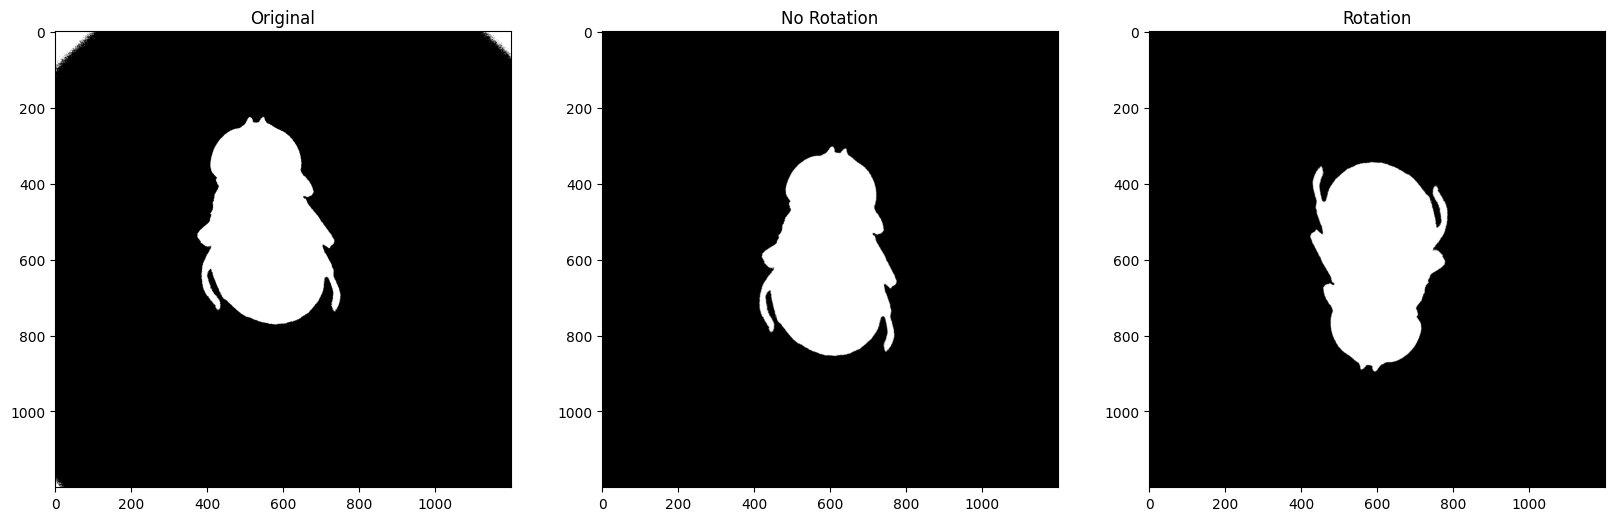

Angle Test!
Angle Value: 89.88645016483065
My Angle Value: 359.7729003296613
Angle Test!
Angle Value: 89.9978370345449
My Angle Value: 359.9956740690898
<< Original Angle: 89.88645016483066 >>
<< No Rotation Angle: 89.88645016483066 >>
<< Rotation Angle: -90.11354983516934 >>


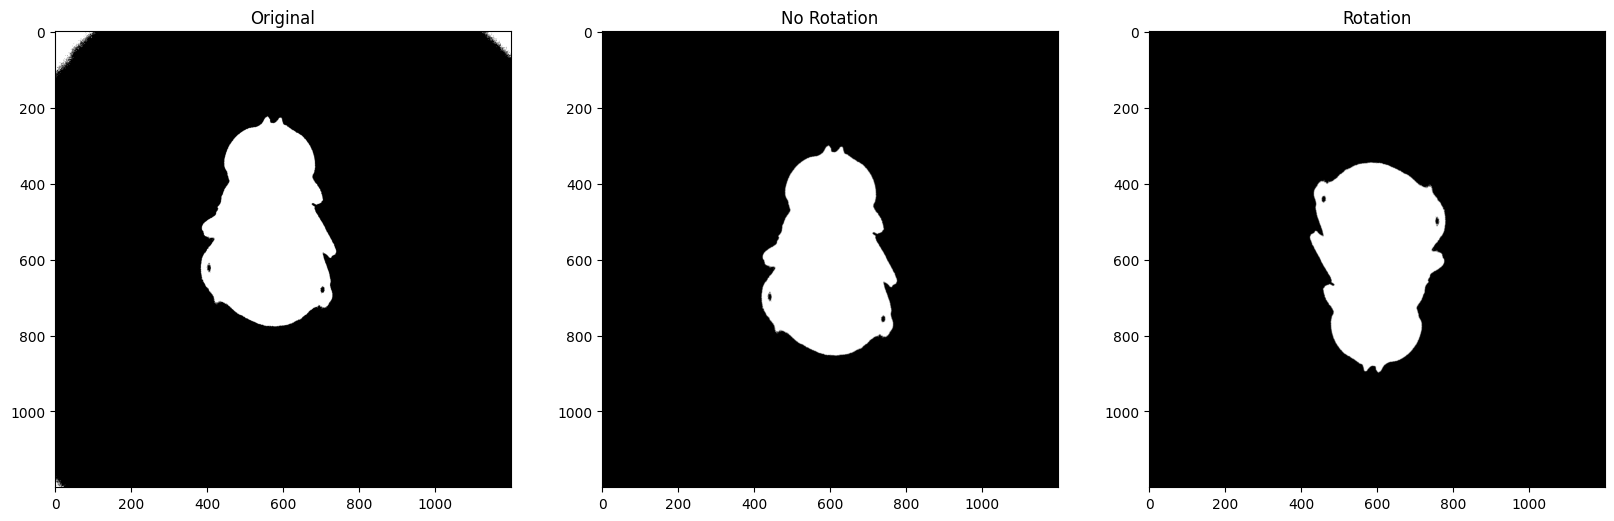

Angle Test!
Angle Value: 98.20328539419498
My Angle Value: 16.406570788389928
Angle Test!
Angle Value: 90.53693549335858
My Angle Value: 1.0738709867171394
<< Original Angle: 98.20328539419498 >>
<< No Rotation Angle: 98.20328539419498 >>
<< Rotation Angle: -81.79671460580502 >>


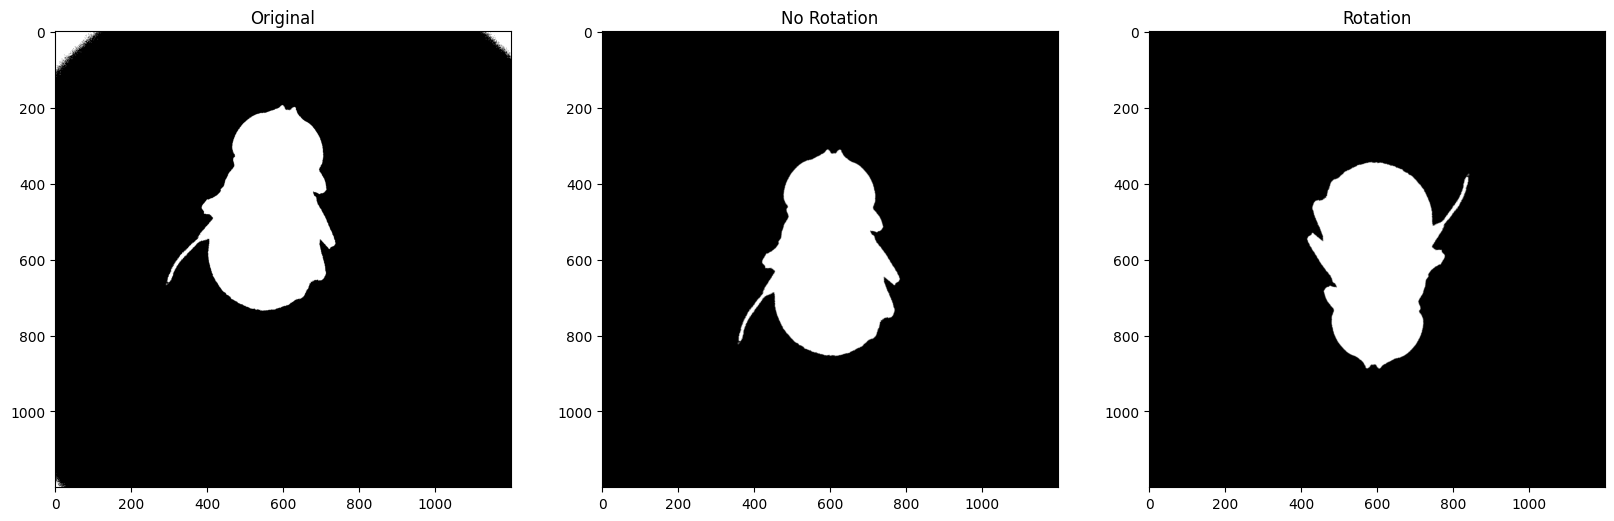

Angle Test!
Angle Value: 93.12274907117508
My Angle Value: 6.245498142350158
Angle Test!
Angle Value: 89.97497909486148
My Angle Value: 359.94995818972296
<< Original Angle: 93.12274907117508 >>
<< No Rotation Angle: 93.12274907117508 >>
<< Rotation Angle: -86.87725092882492 >>


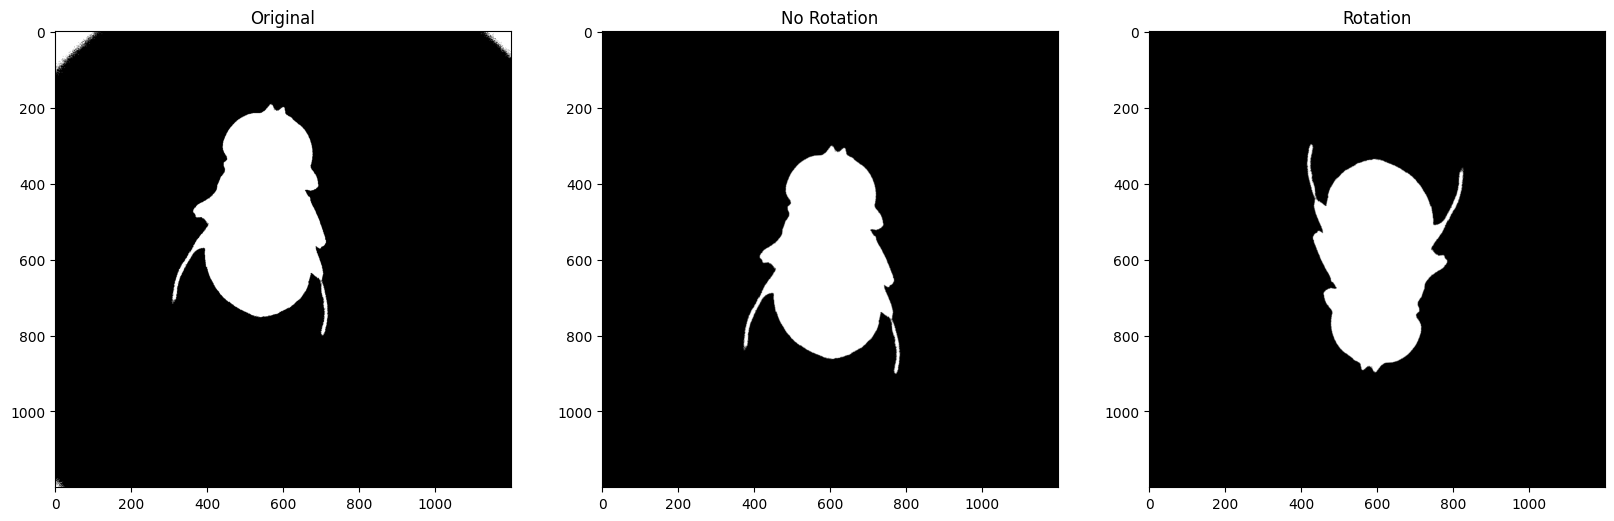

Angle Test!
Angle Value: 137.09171795733045
My Angle Value: 94.18343591466086
Angle Test!
Angle Value: 90.11772742126506
My Angle Value: 0.2354548425301175
<< Original Angle: 137.09171795733045 >>
<< No Rotation Angle: 137.09171795733045 >>
<< Rotation Angle: -42.908282042669555 >>


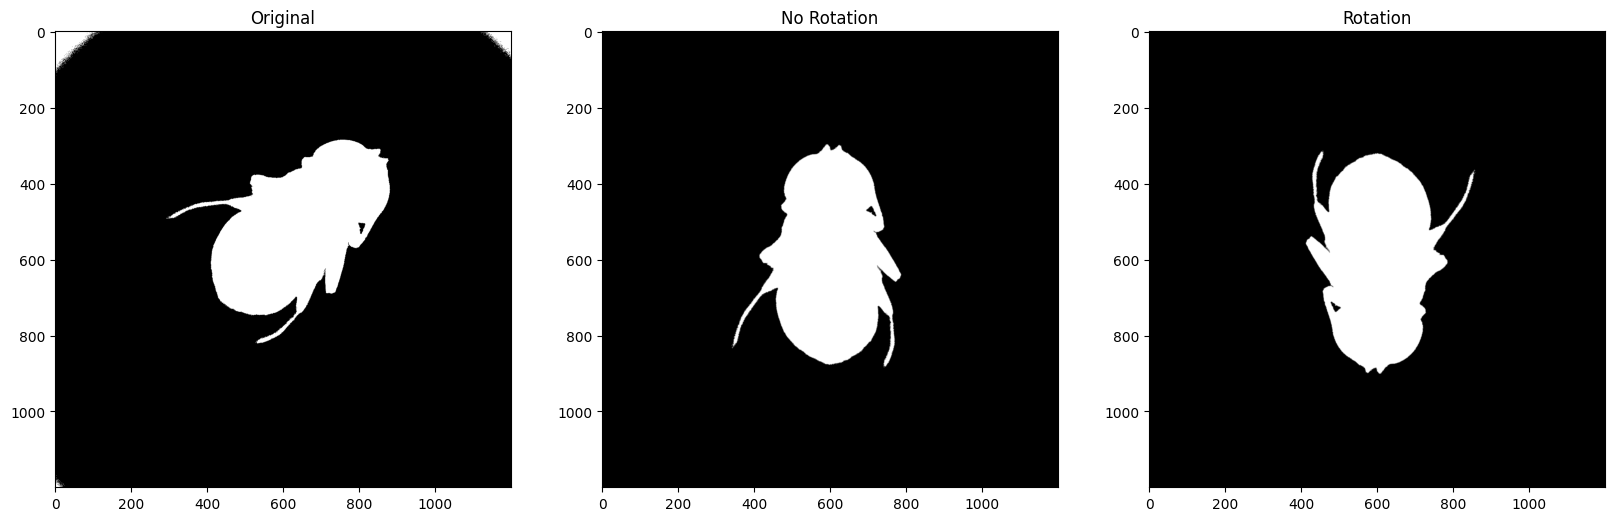

Angle Test!
Angle Value: 152.4498711044786
My Angle Value: 124.89974220895718
Angle Test!
Angle Value: 89.72551463609821
My Angle Value: 359.4510292721964
<< Original Angle: 152.44987110447858 >>
<< No Rotation Angle: 152.44987110447858 >>
<< Rotation Angle: -27.550128895521425 >>


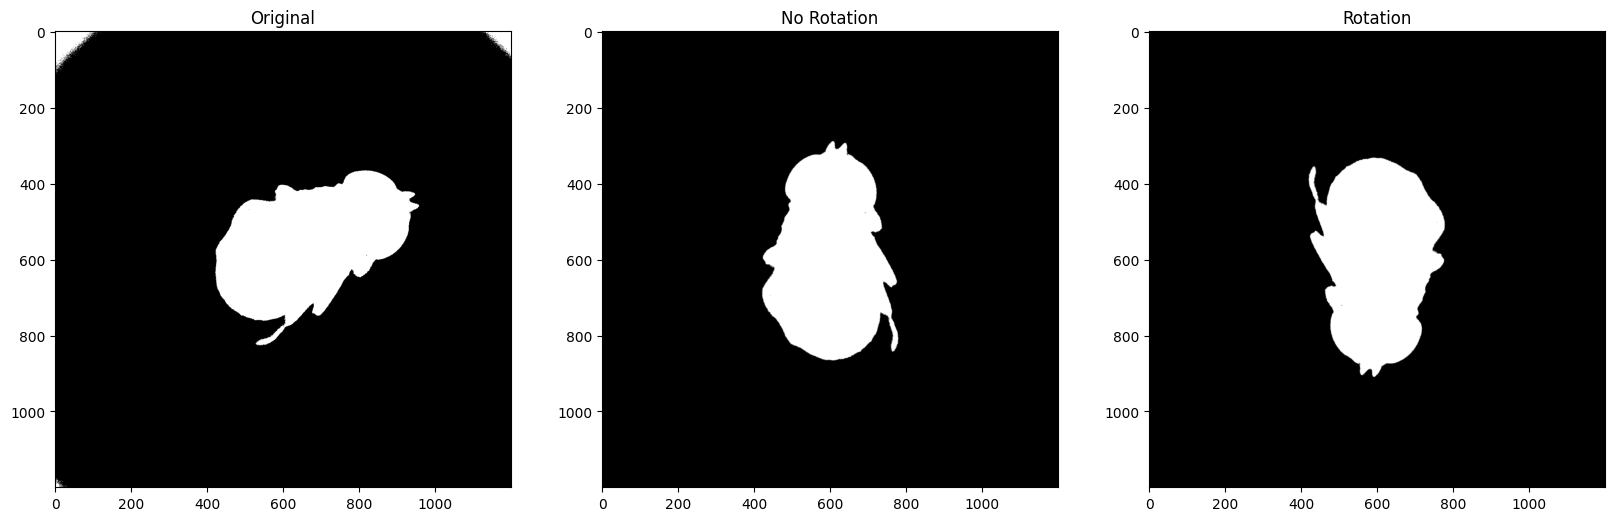

Angle Test!
Angle Value: -140.80339089657733
My Angle Value: 258.39321820684535
Angle Test!
Angle Value: 89.87655718470455
My Angle Value: 359.7531143694091
<< Original Angle: -140.80339089657733 >>
<< No Rotation Angle: -140.80339089657733 >>
<< Rotation Angle: -320.8033908965773 >>


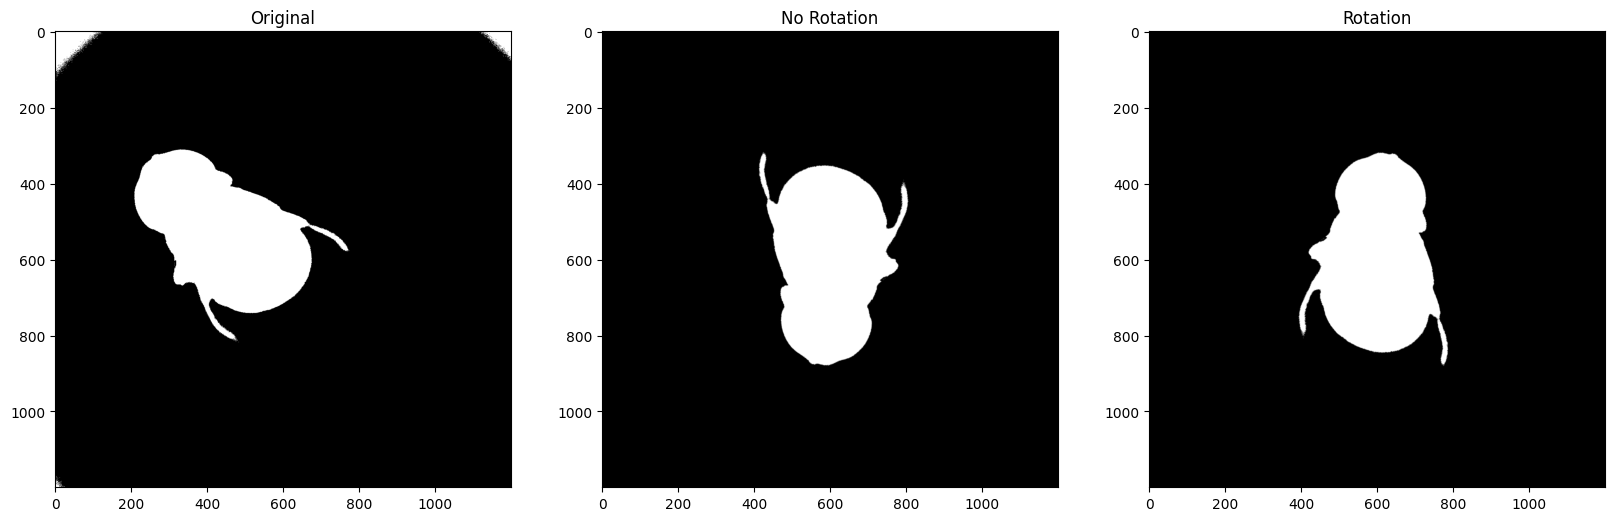

Angle Test!
Angle Value: 49.028333342884544
My Angle Value: 278.0566666857691
Angle Test!
Angle Value: 89.89464788613593
My Angle Value: 359.7892957722719
<< Original Angle: 49.02833334288454 >>
<< No Rotation Angle: 49.02833334288454 >>
<< Rotation Angle: -130.97166665711546 >>


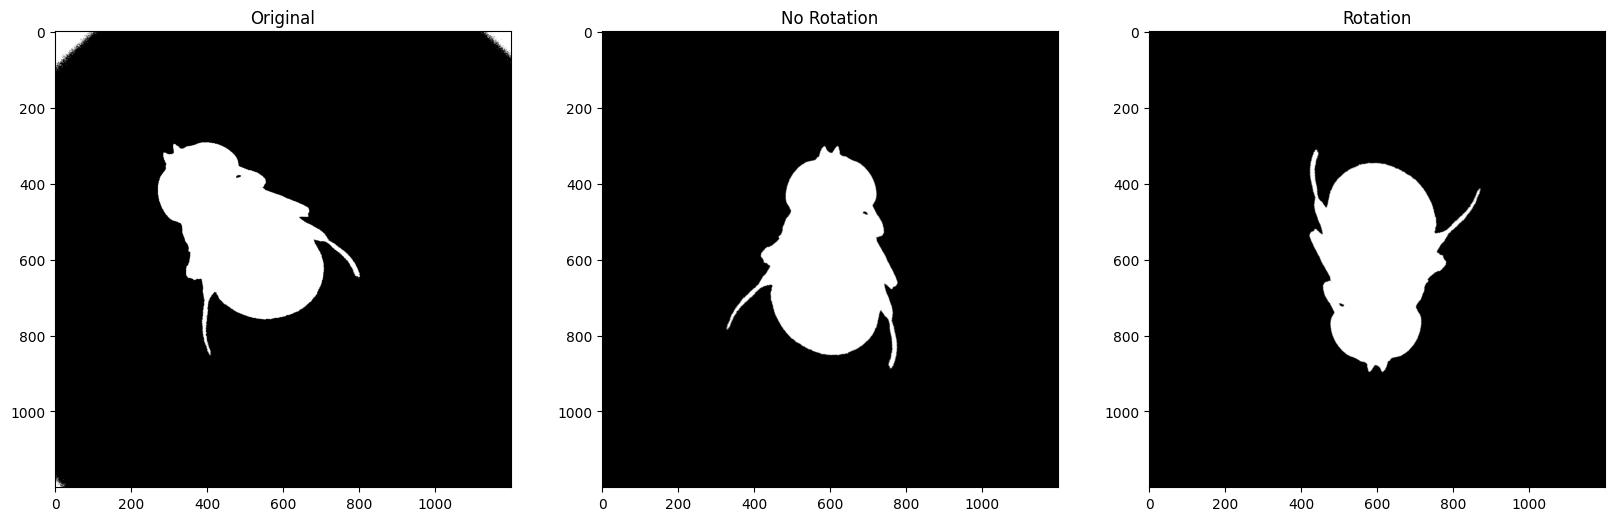

Angle Test!
Angle Value: 86.78831436877194
My Angle Value: 353.57662873754384
Angle Test!
Angle Value: 89.77323256899456
My Angle Value: 359.5464651379891
<< Original Angle: 86.78831436877192 >>
<< No Rotation Angle: 86.78831436877192 >>
<< Rotation Angle: -93.21168563122808 >>


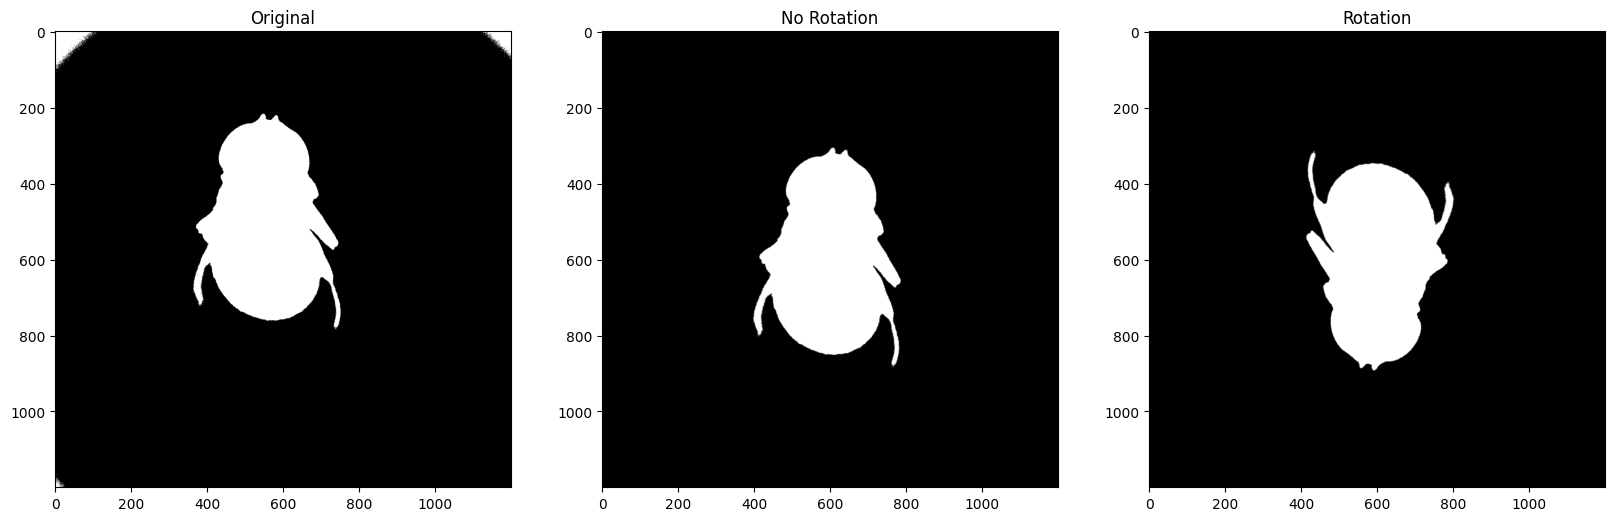

In [48]:
# get all of the files in the folder
# shuffled_list = sorted(glob.glob('/media/flyranch/T7 Shield/flyflipimgs/20240502125110/*.png'), key=lambda x: random.random())
shuffled_list = sorted(data, key=lambda x: random.random())
print(shuffled_list)
for file in shuffled_list[:20]:
    name = file.split('/')[-1].strip('.png')
    mask_fly = img_label(file)
    imgs[name] = mask_fly
    # execute function and then add these images and etc to the dictionary

## Average Fly Mask Template 
Using the 20 labelled images, a grayscale template mask will be developed of the fly facing upward. This average mask will then be tested against all images in the dataset to determine correct orientation.

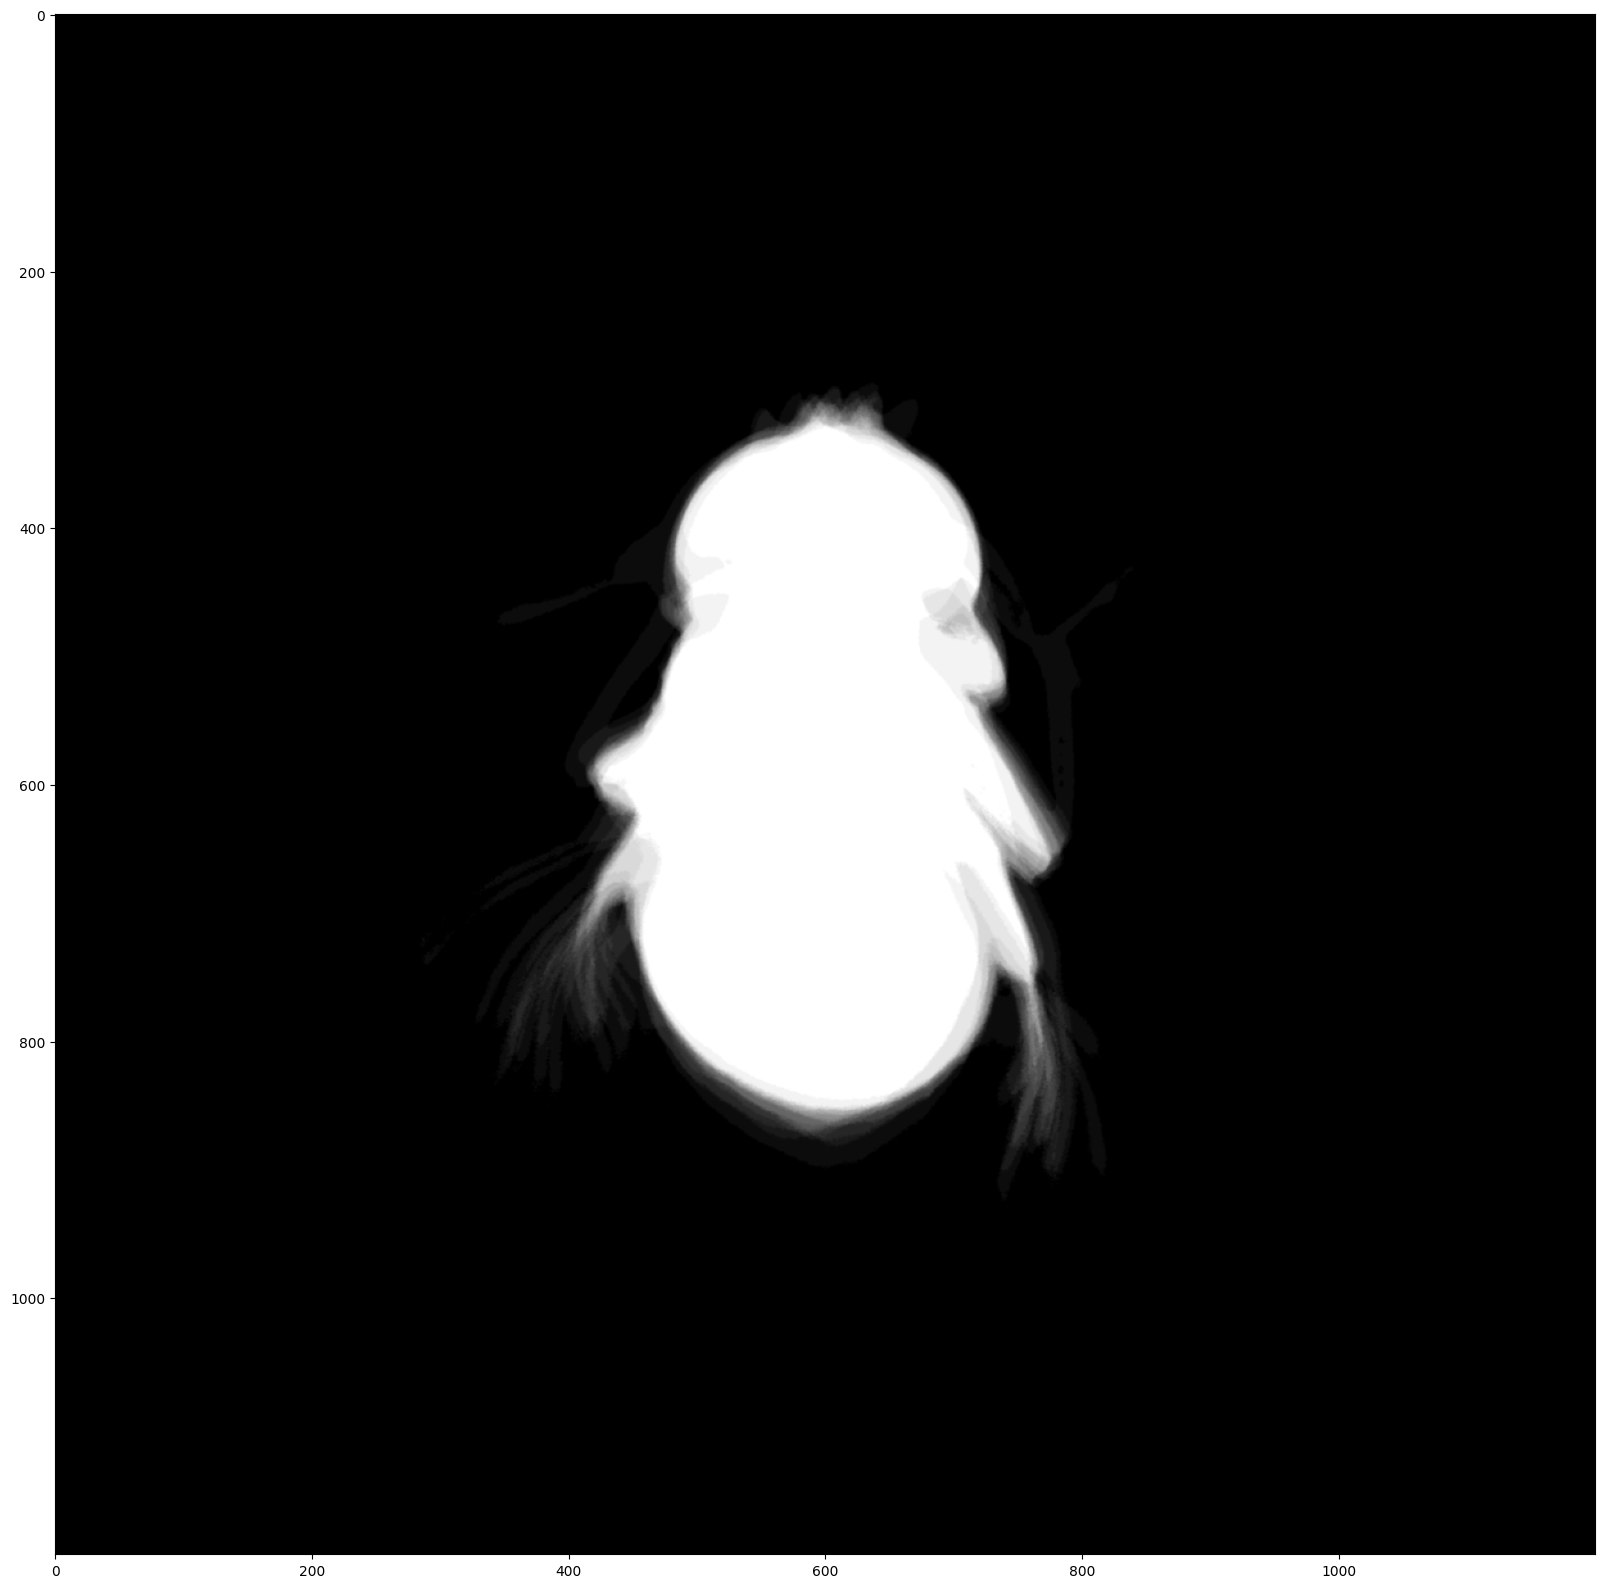

In [49]:
### Now with all the images we will create a mean tempate mask
final = []
for img in imgs.keys():
    final.append(imgs[img])
# print(final)
stacked = np.stack(final,axis=-1)
avg_mask = np.mean(stacked, axis = -1)
plt.figure(figsize=(20,20))
plt.imshow(avg_mask,cmap = 'gray')

## MSE Comparison
The entire image dataset will be tested against this average mask to determine the correct orientation of the fly. The MSE Rot and MSE No Rot will be logged as well as whether fly is No Rot or Rot.

In [50]:
## Comparison between two images
def mse(img1, img2):
    area_px = img1.shape[0]*img1.shape[1]
    px_diff = cv2.subtract(img1, img2)
    sum_err = np.sum(px_diff**2)
    mse = sum_err/(float(area_px))
    return mse
def data_mse(data):
    data_results = {
        "file":[],
        "type":[],
        "MSE":[]
    }
    for file in data:
        name = file.split('/')[-1].strip('.png')
        mask_fly = contour_hrz_matrix(file)[1].astype(float)
        ## No Rotation or Rotation
        d = {
            "MSE No Rotation":mse(avg_mask,mask_fly),
            "MSE Rotation": mse(avg_mask,cv2.rotate(mask_fly,cv2.ROTATE_180))
        }
        # print(d)
        
        ## Save the min MSE Value
        data_results["file"].append(name)
        img_rot_type = list(d.keys())[list(d.values()).index(min(list(d.values())))]
        data_results['type'].append(img_rot_type)
        data_results["MSE"].append((d["MSE No Rotation"],d["MSE Rotation"])) # both MSE values...
        print("----------------")
    return data_results


In [51]:
imgs[list(imgs.keys())[0]].dtype
img1 = imgs[list(imgs.keys())[18]].astype('float64')
error = mse(avg_mask,img1)
error2 = mse(avg_mask,cv2.rotate(img1,cv2.ROTATE_180))
print("No rotation:",error)
print("Rotation:",error2)

No rotation: 270.9216443368056
Rotation: 1220.574681211806


In [35]:
np.random.choice(data)

'/media/loganrower/D5E2-7968/20240502125110/20240502125110_2879.png'

In [52]:
fly_mask_orig1, fly_mask_hrz1,max_contour_hrz,centroid_hrz, body_axis_pt_0_hrz,body_axis_pt_1_hrz,angle_og,angle_rot= contour_hrz_matrix(np.random.choice(data))
img1 = fly_mask_hrz1.astype('float64')
error = mse(avg_mask,img1)
error2 = mse(avg_mask,cv2.rotate(img1,cv2.ROTATE_180))


Angle Test!
Angle Value: 49.42269875049734
My Angle Value: 278.8453975009947
Angle Test!
Angle Value: 90.38773172196863
My Angle Value: 0.775463443937241


<< Original Angle: 49.42269875049733 >>
<< No Rotation Angle: 49.42269875049733 >>
<< Rotation Angle: -130.57730124950268 >>


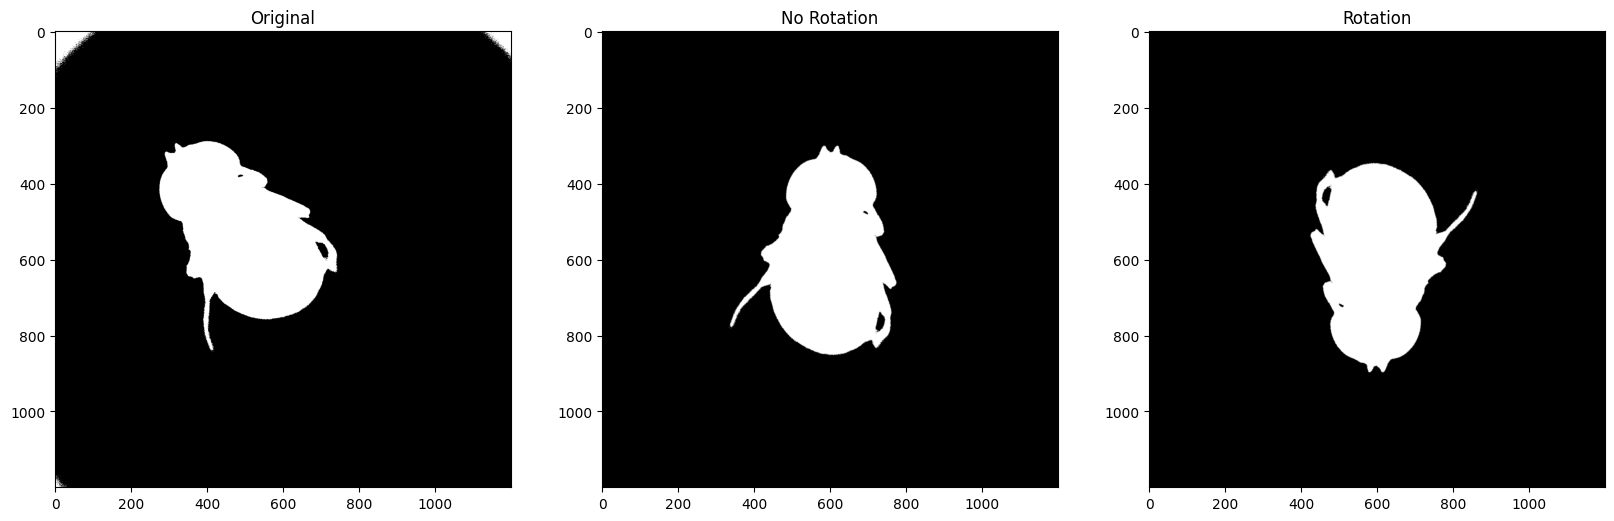

In [53]:
mask_fly_rot1 = cv2.rotate(copy.deepcopy(fly_mask_hrz1),cv2.ROTATE_180)

fig = plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(fly_mask_orig1,cmap='gray')
print(f"<< Original Angle: {np.rad2deg(angle_og)} >>")
plt.subplot(1,3,2)
plt.title("No Rotation")
# print("No Rotation Angle:",np.rad2deg(angle))
print(f"<< No Rotation Angle: {np.rad2deg(angle_og)} >>")
plt.imshow(fly_mask_hrz1,cmap='gray')
plt.subplot(1,3,3)
plt.title("Rotation")
print(f"<< Rotation Angle: {np.rad2deg(angle_og)-180} >>")
plt.imshow(mask_fly_rot1,cmap='gray')
plt.show()

In [55]:
print("No rotation:",error)
print("Rotation:",error2)

No rotation: 333.4620451006946
Rotation: 1250.7048939201386


The `data_mse` function can take from 10-15 min based on size of the dataset.

In [56]:
results = data_mse(data)
results

Angle Test!
Angle Value: -151.56315612336587
My Angle Value: 236.87368775326829
Angle Test!
Angle Value: 89.95270842557198
My Angle Value: 359.90541685114397
----------------
Angle Test!
Angle Value: 171.74574168845953
My Angle Value: 163.49148337691906
Angle Test!
Angle Value: 89.86981333873817
My Angle Value: 359.73962667747634
----------------
Angle Test!
Angle Value: 145.2359769345717
My Angle Value: 110.47195386914338
Angle Test!
Angle Value: 89.75972890132275
My Angle Value: 359.5194578026455
----------------
Angle Test!
Angle Value: -175.96815834466332
My Angle Value: 188.06368331067338
Angle Test!
Angle Value: 89.8033080949423
My Angle Value: 359.60661618988456
----------------
Angle Test!
Angle Value: -156.8539241398017
My Angle Value: 226.29215172039665
Angle Test!
Angle Value: 89.87424645787968
My Angle Value: 359.74849291575936
----------------
Angle Test!
Angle Value: 61.19982473095833
My Angle Value: 302.3996494619167
Angle Test!
Angle Value: 89.8312433454884
My Angle Val

{'file': ['20240502125110_0008',
  '20240502125110_0011',
  '20240502125110_0024',
  '20240502125110_0026',
  '20240502125110_0027',
  '20240502125110_0029',
  '20240502125110_0031',
  '20240502125110_0041',
  '20240502125110_0046',
  '20240502125110_0052',
  '20240502125110_0062',
  '20240502125110_0104',
  '20240502125110_0105',
  '20240502125110_0138',
  '20240502125110_0192',
  '20240502125110_0203',
  '20240502125110_0209',
  '20240502125110_0212',
  '20240502125110_0215',
  '20240502125110_0230',
  '20240502125110_0235',
  '20240502125110_0240',
  '20240502125110_0258',
  '20240502125110_0259',
  '20240502125110_0265',
  '20240502125110_0292',
  '20240502125110_0296',
  '20240502125110_0306',
  '20240502125110_0307',
  '20240502125110_0311',
  '20240502125110_0330',
  '20240502125110_0351',
  '20240502125110_0370',
  '20240502125110_0376',
  '20240502125110_0407',
  '20240502125110_0410',
  '20240502125110_0415',
  '20240502125110_0422',
  '20240502125110_0423',
  '20240502125110

The dictionary is then transformed into a dataframe for additional processing and subsequent plotting

In [57]:
results_df = pd.DataFrame(results)
results_df.head()

file             type  \
0  20240502125110_0008  MSE No Rotation   
1  20240502125110_0011     MSE Rotation   
2  20240502125110_0024     MSE Rotation   
3  20240502125110_0026     MSE Rotation   
4  20240502125110_0027     MSE Rotation   

                                        MSE  
0    (426.32421725347206, 982.692552114583)  
1   (1109.7904704479167, 396.3088703090276)  
2  (1236.0150348229167, 442.22202940624976)  
3   (1252.3817889895836, 429.8394007951387)  
4   (1279.299954684028, 444.11299267013874)

# Plot all data

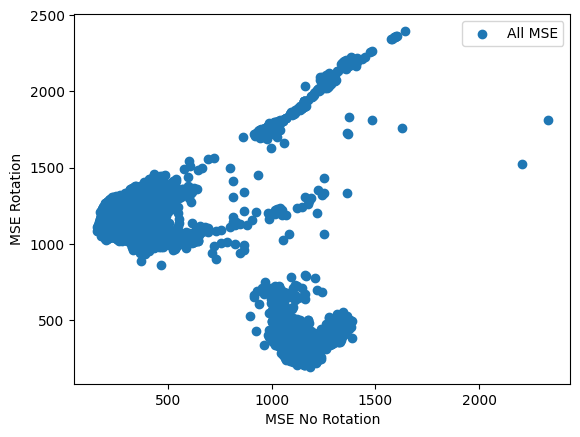

In [58]:
plt.scatter(results_df['MSE'].apply(lambda x: x[0]),results_df['MSE'].apply(lambda x: x[1]),label = 'All MSE')
plt.xlabel('MSE No Rotation')
plt.ylabel('MSE Rotation')
plt.legend()

## Plot of MSE ERROR No Rotation vs Rotation for Large Dataset

Using the average mask from before we will now look at all the images in the dataset to determine accuracy. 

In [88]:
results_df

file             type  \
0     20240502125110\20240502125110_0008  MSE No Rotation   
1     20240502125110\20240502125110_0011     MSE Rotation   
2     20240502125110\20240502125110_0024     MSE Rotation   
3     20240502125110\20240502125110_0026     MSE Rotation   
4     20240502125110\20240502125110_0027     MSE Rotation   
...                                  ...              ...   
8857  20240502125110\20240502125110_8799  MSE No Rotation   
8858  20240502125110\20240502125110_8817     MSE Rotation   
8859  20240502125110\20240502125110_8842     MSE Rotation   
8860  20240502125110\20240502125110_8851     MSE Rotation   
8861  20240502125110\20240502125110_8861  MSE No Rotation   

                                           MSE  
0     (396.37027653238374, 1007.3766886851608)  
1     (1134.8088490026214, 362.66883923079644)  
2     (1264.0470191415106, 400.93834305024075)  
3      (1277.8443045581776, 394.6114088736535)  
4      (1304.3256458280187, 409.9326055502408)  
...                                        ...  
8857  (326.11751428039975, 1169.2134086256374)  
8858  (1218.8059533677017, 239.98722821889186)  
8859  (1225.3036141811938, 247.94541269309818)  
8860   (1218.824612147463, 244.87449682008227)  
8861  (303.46789567920905, 1183.6592810958762)  

[8862 rows x 3 columns]

In [59]:
# Plot Type MSE NO ROTATION with VALUE MSE (X AXIS)
mse_norot = results_df[results_df['type']=='MSE No Rotation']
print(mse_norot)
mse_rot = results_df[results_df['type']=='MSE Rotation']
print(mse_rot)


                     file             type  \
0     20240502125110_0008  MSE No Rotation   
5     20240502125110_0029  MSE No Rotation   
6     20240502125110_0031  MSE No Rotation   
8     20240502125110_0046  MSE No Rotation   
10    20240502125110_0062  MSE No Rotation   
...                   ...              ...   
8842  20240502125110_8649  MSE No Rotation   
8845  20240502125110_8679  MSE No Rotation   
8849  20240502125110_8730  MSE No Rotation   
8857  20240502125110_8799  MSE No Rotation   
8861  20240502125110_8861  MSE No Rotation   

                                           MSE  
0       (426.32421725347206, 982.692552114583)  
5      (422.6155957256943, 1294.2493155868056)  
6      (417.0711192673611, 1313.6275957256946)  
8      (374.1268701701388, 1268.2304344756951)  
10     (347.0058382256946, 1287.1355089895835)  
...                                        ...  
8842    (313.6926533645833, 1185.957534267361)  
8845    (376.3558260034722, 1157.221091767361)  
8849  

In [90]:
len(results_df)


8862

In [92]:
len(mse_norot)


6509

0       5400.000387
1       6981.284394
2       6723.951834
3       7027.140760
4       7201.448330
           ...     
8854    6397.122814
8855    6883.384758
8858    6830.338330
8859    6337.198682
8860    7106.547459
Name: MSE, Length: 5382, dtype: float64

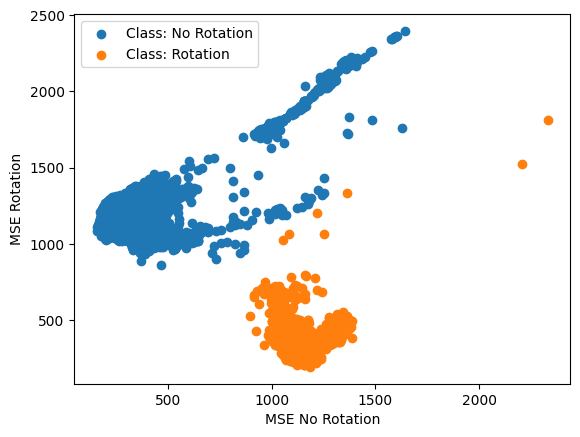

In [60]:
plt.scatter(mse_norot['MSE'].apply(lambda x: x[0]),mse_norot['MSE'].apply(lambda x: x[1]),label = 'Class: No Rotation')
plt.scatter(mse_rot['MSE'].apply(lambda x: x[0]),mse_rot['MSE'].apply(lambda x: x[1]),label = 'Class: Rotation')
# Plot TYPE MSE ROTATIO with VALUE MSE (Y axis)

plt.xlabel('MSE No Rotation')
plt.ylabel('MSE Rotation')
plt.legend()

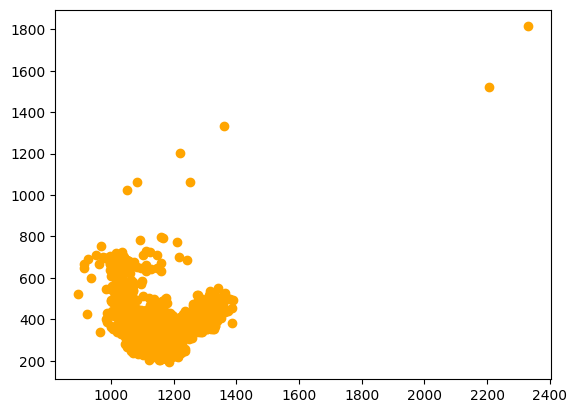

In [63]:
plt.scatter(np.array(mse_rot['MSE'].apply(lambda x: x[0])),np.array(mse_rot['MSE'].apply(lambda x: x[1])),color = 'orange',label = 'Class: Rotation')

# Original Fly Trace

In [142]:
# Import libraries regarding the trace...
from lib.parsing import basic_sections as bsc_sec # basic data parsing methods
from lib.parsing.data_range import find_startdata, find_enddata # setting start and end of analysis region 
from lib.parsing.exact_exp_groups import sub_exp_group,sub_exp_groupv2  # more dataparsing methods
from lib.led_convert import get_LED_angle_in_rad

ImportError: cannot import name 'sub_exp_groupv2' from 'lib.parsing.exact_exp_groups' (/home/loganrower/project_repos/flyplot/lib/parsing/exact_exp_groups.py)

In [150]:
def dark_led_positions(data):
    """
    Parameters:
        - data -> the data for the fly.
    return start time for experiment and the dark mode
    """
    ## Start of dark period
    start_time_idx = data[(data['led position'] ==150) | (data['led position'] ==149)].index[0]
    start_time = data['time'][start_time_idx]
    ## find the point in which there is change in led_position
    end_time_idx = 0
    led_pos = data['led position'][start_time_idx:]
    for pnt in range(start_time_idx , len(data['led position'])): #checking values until we find a match
        if data['led position'][pnt] != 150 and data['led position'][pnt] != 149:
            end_time_idx = pnt # the index for the dark mode ending
            break
    end_time = data['time'][end_time_idx]
    


    ## get the indicies for the the last dark period

    return start_time, start_time_idx,end_time, end_time_idx

def cali_led_pos(data,df):
    """
    Parameters:
        - data -> the data for the fly (time, led position...etc)
    return the starting and ending index for the calibration
    """
    
    ## Start of dark period
    start_time_idx = data[(data['led position'] ==-1)].index[0]
    start_time = data['time'][start_time_idx]
    ## find the point in which there is change in led_position
    end_time_idx = 0
    led_pos = data['led position'][start_time_idx:]
    for pnt in range(start_time_idx , len(data['led position'])): #checking values until we find a match
        if data['led position'][pnt] != -1:
            end_time_idx = pnt # the index for the dark mode ending
            break
    end_time = data['time'][end_time_idx]
    df['cali'] = (start_time_idx,end_time_idx)
    # return df

def all_dark_led_pos(data,df):
    """
    Parameters:
        - data -> the data for the fly.
    return all dark led positions
    """    
    dark_led_lst=[]
    start_run = True
    led_pair = [None,None]
    count_dark = 0
    for led in range(1,len(data['led position'])):
        diff = abs(data['led position'][led]-data['led position'][led-1])
        if ((diff == 0) | (diff == 1)) and ((data['led position'][led-1] ==150) | (data['led position'][led-1] ==149)):
        # if (diff == 0 or diff == 1) and (data['led position'][led] == 150 or data['led position'][led] == 149):
            if start_run:
                start_run = False
                led_pair[0] = led-1
                # print("led pair",led_pair,start_run)
        elif diff > 1 and ((data['led position'][led] !=150) | (data['led position'][led] !=149)) and (start_run == False):
            start_run = True
            led_pair[1] = led
            dark_led_lst.append(tuple(led_pair))
            count_dark +=1
            df["dark_"+str(count_dark)] = tuple(led_pair)
            led_pair = [None,None]
            
            
        if ( led == len(data['led position'])-1) and (start_run == False) and ((data['led position'][led] == 150) | (data['led position'][led] == 149)):
            start_run = True
            led_pair[1] = led
            dark_led_lst.append(tuple(led_pair))
            count_dark +=1
            df["dark_"+str(count_dark)] = tuple(led_pair)
            led_pair = [None,None]
    # return dark_led_lst
def all_static_led_pos(data,df):
    """
    Parameters:
        - data -> the data for the fly.
    return the ranges of the different static led experiments that are not dark...
    """    
    static_led_lst=[]
    start_run = True
    led_pair = [None,None]
    count_static=0
    for led in range(1,len(data['led position'])):
        diff = abs(data['led position'][led]-data['led position'][led-1])
        if (diff == 0) and ((data['led position'][led-1] !=150) and (data['led position'][led-1] !=149) and (data['led position'][led-1] !=-1)):
            if start_run:
                start_run = False
                led_pair[0] = led-1
        elif (diff > 1) and (led>2) and (data['led position'][led-1] == data['led position'][led-2]) and (start_run == False):
            start_run = True
            led_pair[1] = led
            static_led_lst.append(tuple(led_pair))
            count_static +=1
            df["static_"+str(count_static)] = tuple(led_pair)
            led_pair = [None,None]

    return static_led_lst

def all_loop_led_pos(data,df):
    """
    Parameters:
        - data -> the data for the fly.
    return the ranges of the different looping led experiments
    """    
    loop_led_lst=[]
    start_run = True
    led_pair = [None,None]
    count_loop = 0
    for led in range(1,len(data['led position'])):
        diff = abs(data['led position'][led]-data['led position'][led-1])
        if (diff == 1) and ((data['led position'][led-1] !=150) and (data['led position'][led-1] !=149) and (data['led position'][led-1] !=-1)):
            if start_run:
                start_run = False
                led_pair[0] = led
                print(led_pair)
        elif (diff == 0) and (led>2) and (data['led position'][led-1]== data['led position'][led-2])and(data['led position'][led-1] != data['led position'][led]) and (start_run == False):
            start_run = True
            led_pair[1] = led
            loop_led_lst.append(tuple(led_pair))
            count_loop +=1
            df["loop_"+str(count_loop)] = tuple(led_pair)
            led_pair = [None,None]

    return loop_led_lst


In [163]:
def sub_exp_groupv2(data):
    """

    REVISED FOR ALL CONDITIONS!


    creates dictionary that holds the ranges of time in seconds
    for the different periods which occur within the experiment

    Ex:
    {
    'cali':[0,9],
    'dark1':[9,946],
    'loop1':[946,1075],
    'loop2':[1074,1202]
    }

    Where the first 10 seconds is calibration followed by a dark period, and then some experimental looping periods.
    """

    # get from end of dark period/start of first sub experiment to the start of the the last dark period...
    ## empty list for groups... will add start and end sub indexes as sub lists...
    fly_dict = {} 
    cali_led_pos(data,fly_dict)
    all_dark_led_pos(data,fly_dict)
    all_static_led_pos(data,fly_dict)
    all_loop_led_pos(data, fly_dict)

    fly_dict = {w: fly_dict[w] for w in sorted(fly_dict, key=fly_dict.get, reverse=False)}

    return fly_dict

In [166]:
# data source
dat_static ='/media/loganrower/D5E2-7968/20240502125110_data/20240502125110.txt'
os.path.exists('/media/loganrower/D5E2-7968/20240502125110_data/20240502125110.txt')
# female fly heading and led position data
df_fem_static = pd.read_csv(dat_static, names = ['time','fly heading','led position'],sep = " ")

# compute change over time
df_fem_static['delta-t'] = df_fem_static['time'] - df_fem_static['time'][0] 

# compute LED position in degrees
df_fem_static['led angle'] = np.rad2deg(get_LED_angle_in_rad(df_fem_static['led position'])) 

# print(cali_led_pos(df_fem_static))
# print(all_dark_led_pos(df_fem_static))
# print(all_static_led_pos(df_fem_static))
# print(all_loop_led_pos(df_fem_static))
fly_dict = sub_exp_groupv2(df_fem_static)
fly_dict
# get subgroups
# fem_dict_static = sub_exp_group(df_fem_static)
# print(fem_dict_static)
# print(len(fem_dict_static))


{'cali': (0, 6),
 'dark_1': (6, 921),
 'static_1': (921, 2740),
 'static_2': (2740, 4518),
 'static_3': (4518, 6214),
 'static_4': (6214, 7966),
 'dark_2': (7966, 8861)}

Text(0, 0.5, 'Heading/LED Angle')

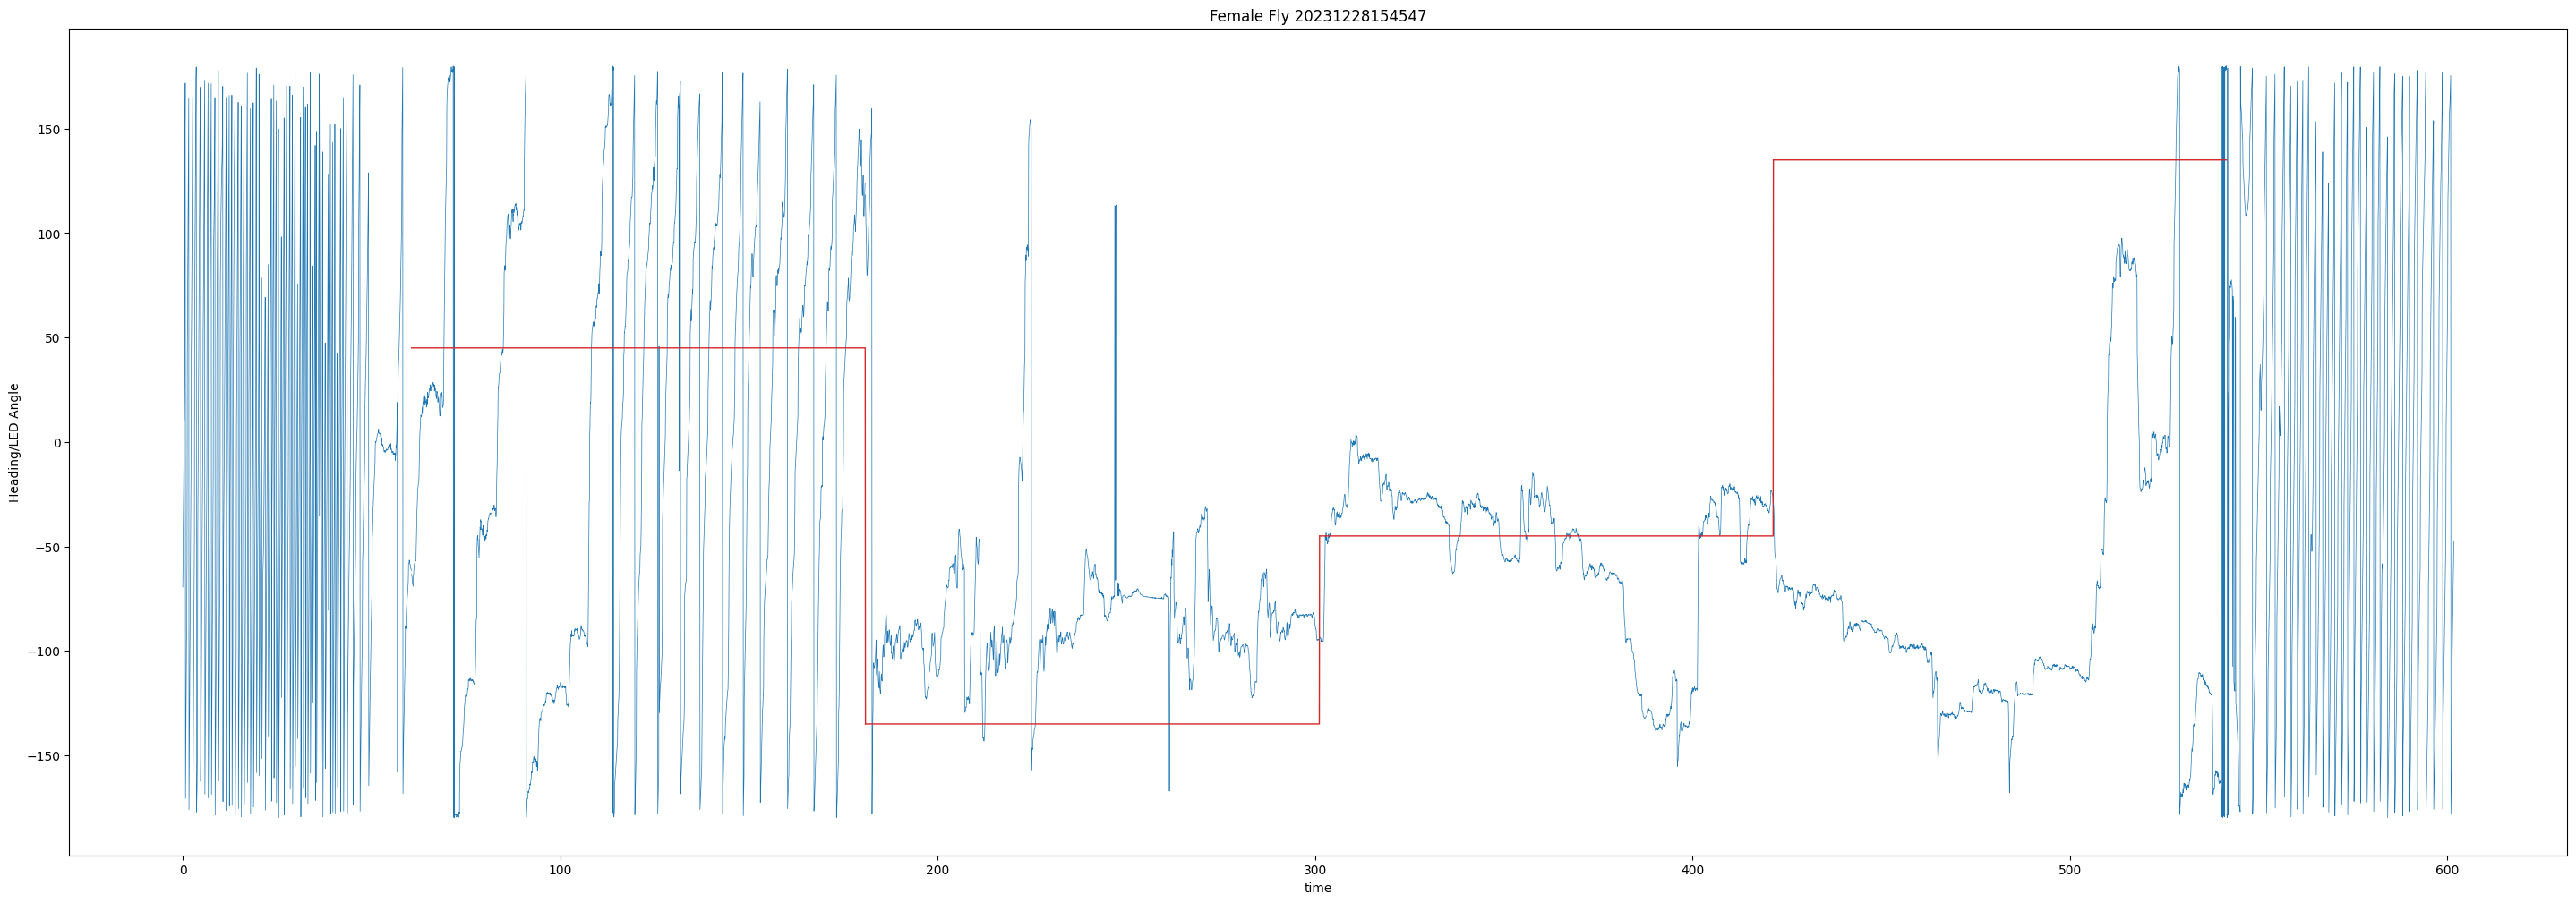

In [172]:
plt.figure(figsize=(36,12))
# iterate over the sections
for k in list(fly_dict.keys()):
    start = fly_dict[k][0]
    end = fly_dict[k][1]
    # print(start,end)
    plt.plot(df_fem_static['delta-t'][start:end],df_fem_static['fly heading'][start:end],color = 'tab:blue', linewidth = .5, label = 'Heading')
    plt.plot(df_fem_static['delta-t'][start:end+1],df_fem_static['led angle'][start:end+1],color = 'tab:red', linewidth = 1, label = 'LED')
plt.title("Female Fly 20231228154547")
plt.xlabel("time")
plt.ylabel("Heading/LED Angle")

# Reestablish a new Textfile 

# New vs Original Plot

# EXTRAS

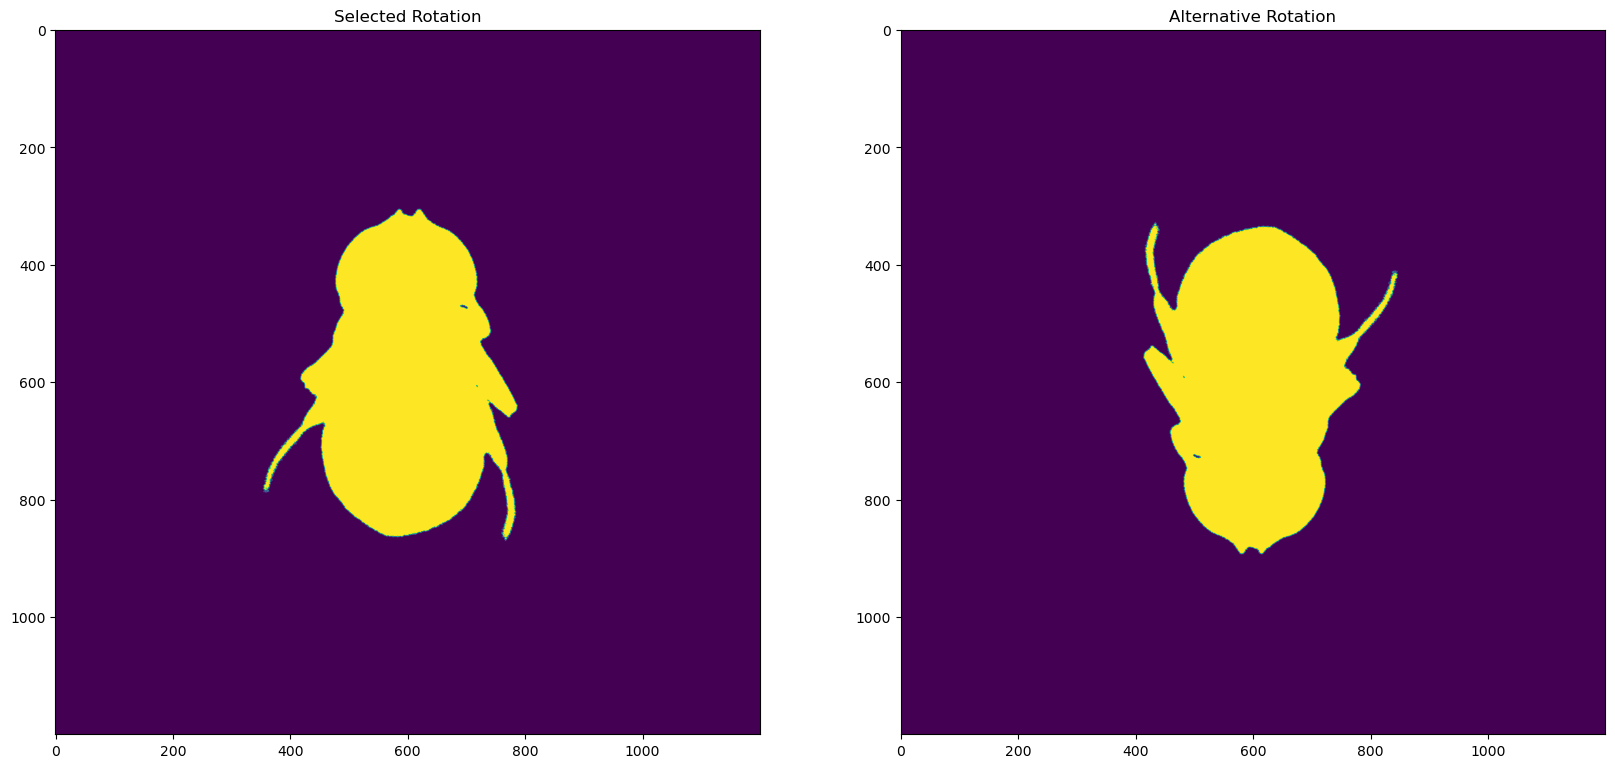

In [42]:
## Test Image (18th image in the stack)
img1 = imgs[list(imgs.keys())[18]].astype('float64')
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.title("Selected Rotation")
plt.imshow(img1) 
plt.subplot(122)
plt.title("Alternative Rotation")
plt.imshow(cv2.rotate(img1,cv2.ROTATE_180))

In [43]:
## Comparison between two images
def mse(img1, img2):
    area_px = img1.shape[0]*img1.shape[1]
    px_diff = cv2.subtract(img1, img2)
    sum_err = np.sum(px_diff**2)
    mse = sum_err/(float(area_px))
    return mse
error = mse(avg_mask,img1)
error2 = mse(avg_mask,cv2.rotate(img1,cv2.ROTATE_180))
print("No rotation:",error)
print("Rotation:",error2)

No rotation: 255.10822447569433
Rotation: 1138.383849197916


In [20]:
fly_mask_hrz = fly_mask_hrz.astype('float64')
error = mse(avg_mask,fly_mask_hrz)
error2 = mse(avg_mask,cv2.rotate(fly_mask_hrz,cv2.ROTATE_180))
print("No rotation:",error)
print("Rotation:",error2)

No rotation: 1946.0575228090283
Rotation: 1709.1743328090274
